In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pandas as pd
import glob
import os

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("PART 1: DATA LOADING AND EXPLORATION")

df = pd.read_csv("textile_with_exogenous_FINAL.csv")

df["date"] = pd.to_datetime(df["date"])

PART 1: DATA LOADING AND EXPLORATION


In [3]:
import pandas as pd
import os
import numpy as np


def load_and_clean_historical_data():
    historical_file = "2011-2017.csv"

    if os.path.exists(historical_file):
        print(f"Loading {historical_file}...")
        # FIX: index_col=False prevents the trailing comma from shifting columns
        temp_df = pd.read_csv(historical_file, index_col=False)

        # Select relevant columns
        temp_df = temp_df[
            ["period", "reporterDesc", "cmdCode", "flowDesc", "primaryValue"]
        ]

        temp_df = temp_df.rename(
            columns={
                "reporterDesc": "reporter_name",
                "cmdCode": "hs_code",
                "flowDesc": "flow",
                "primaryValue": "primaryValue",
            }
        )

        temp_df["period"] = temp_df["period"].astype(str)
        temp_df["date"] = pd.to_datetime(temp_df["period"], format="%Y%m")

        temp_df["year"] = temp_df["date"].dt.year
        temp_df["month"] = temp_df["date"].dt.month

        print(f"Successfully loaded {len(temp_df)} historical records from 2011-2017.")
        return temp_df
    else:
        print(f"Historical file {historical_file} not found.")
        return None


# Run the function to load the new data
df_historical = load_and_clean_historical_data()

# Load your existing 2018-2022 dataset
# Ensure this file is in the same folder or update the path
df_current = pd.read_csv("textile_with_exogenous_FINAL.csv")
df_current["date"] = pd.to_datetime(df_current["date"])

if df_historical is not None:
    # 1. Merge the datasets
    df_combined = pd.concat([df_historical, df_current], ignore_index=True)

    # 2. Sort by date and category
    df_combined = df_combined.sort_values(by=["date", "reporter_name", "hs_code"])

    # 3. Handle Missing Exogenous Variables for 2011-2017
    # The new files don't have GDP/Exchange Rates, so we must fill them to avoid model errors.
    # We use backfill (bfill) to propagate 2018 values backwards to 2011 as a placeholder.
    exog_cols = [
        "cotton_ppi",
        "textile_ppi",
        "usd_cny",
        "usd_inr",
        "gdp_growth",
        "industrial_prod",
    ]

    # Ensure columns exist
    for col in exog_cols:
        if col not in df_combined.columns:
            df_combined[col] = np.nan

    # Group by Country to ensure we don't mix up exchange rates (e.g. India vs China)
    # Then forward fill (ffill) and back fill (bfill)
    df_combined[exog_cols] = df_combined.groupby("reporter_name")[exog_cols].transform(
        lambda x: x.fillna(method="bfill").fillna(method="ffill")
    )

    # Update the main dataframe
    df = df_combined

    print(f"Merged Dataset Total Records: {len(df)}")
    print(f"New Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
else:
    df = df_current
    print("Using only original dataset (2018-2022).")

# Check for duplicates or anomalies
print(df.head())

Loading 2011-2017.csv...
Successfully loaded 84 historical records from 2011-2017.
Merged Dataset Total Records: 45413
New Date Range: 2011-01-01 to 2022-12-01
   period reporter_name  hs_code    flow  primaryValue       date    year  \
0  201101         India       52  Import  3.031555e+07 2011-01-01  2011.0   
1  201102         India       52  Import  4.564154e+07 2011-02-01  2011.0   
2  201103         India       52  Import  3.093189e+07 2011-03-01  2011.0   
3  201104         India       52  Import  5.411487e+07 2011-04-01  2011.0   
4  201105         India       52  Import  6.599398e+07 2011-05-01  2011.0   

   month typeCode freqCode  ...  year_x  month_x  cotton_ppi  textile_ppi  \
0    1.0      NaN      NaN  ...     NaN      NaN       111.2        117.4   
1    2.0      NaN      NaN  ...     NaN      NaN       111.2        117.4   
2    3.0      NaN      NaN  ...     NaN      NaN       111.2        117.4   
3    4.0      NaN      NaN  ...     NaN      NaN       111.2        1

In [4]:
print(f"\n✓ Dataset loaded: {len(df):,} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Columns: {len(df.columns)}")


✓ Dataset loaded: 45,413 records
Date range: 2011-01-01 00:00:00 to 2022-12-01 00:00:00
Columns: 63


In [5]:
print(f"\nCountries: {df['reporter_name'].unique()}")
print(f"HS Codes: {df['hs_code'].unique()}")
print(f"Flows: {df['flow'].unique()}")


Countries: ['India' 'China' 'USA']
HS Codes: [52 55 60]
Flows: ['Import' 'Export']


In [6]:
# Records per country
print("\nRecords per country:")
print(df["reporter_name"].value_counts())


Records per country:
reporter_name
China    27175
India    17011
USA       1227
Name: count, dtype: int64


In [7]:
print("\nRecords per HS code:")
print(df["hs_code"].value_counts())


Records per HS code:
hs_code
52    19282
55    14644
60    11487
Name: count, dtype: int64


In [8]:
print("CREATING AGGREGATED MONTHLY TIME SERIES")

# Aggregate by month, country, HS code, flow
monthly_agg = (
    df.groupby(["date", "reporter_name", "hs_code", "flow"])
    .agg(
        {
            "primaryValue": "sum",  # Total trade value
            "qty": "sum",  # Total quantity
            "netWgt": "sum",  # Total weight
            "partnerCode": "nunique",  # Number of trading partners
            # FRED variables (take mean as they're same for all records in a month)
            "cotton_ppi": "mean",
            "textile_ppi": "mean",
            "usd_cny": "mean",
            "usd_inr": "mean",
            "gdp_growth": "mean",
            "industrial_prod": "mean",
        }
    )
    .reset_index()
)

# Rename partner count column
monthly_agg.rename(columns={"partnerCode": "num_partners"}, inplace=True)

print(f"\n Created {len(monthly_agg)} monthly observations")

# Save aggregated data
monthly_agg.to_csv("monthly_aggregated_timeseries.csv", index=False)

CREATING AGGREGATED MONTHLY TIME SERIES

 Created 588 monthly observations


In [9]:
# Show sample
print("\nSample of aggregated data:")
print(monthly_agg.head(10))


Sample of aggregated data:
        date reporter_name  hs_code    flow  primaryValue  qty  netWgt  \
0 2011-01-01         India       52  Import  3.031555e+07  0.0     0.0   
1 2011-02-01         India       52  Import  4.564154e+07  0.0     0.0   
2 2011-03-01         India       52  Import  3.093189e+07  0.0     0.0   
3 2011-04-01         India       52  Import  5.411487e+07  0.0     0.0   
4 2011-05-01         India       52  Import  6.599398e+07  0.0     0.0   
5 2011-06-01         India       52  Import  5.389772e+07  0.0     0.0   
6 2011-07-01         India       52  Import  3.939660e+07  0.0     0.0   
7 2011-08-01         India       52  Import  3.150586e+07  0.0     0.0   
8 2011-09-01         India       52  Import  2.900414e+07  0.0     0.0   
9 2011-10-01         India       52  Import  3.313634e+07  0.0     0.0   

   num_partners  cotton_ppi  textile_ppi   usd_cny    usd_inr  gdp_growth  \
0             0       111.2        117.4  6.423295  63.645238         3.3   
1  

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("TEXTILE IMPORT FORECASTING - EXPLORATORY DATA ANALYSIS")

# Load data
monthly_agg = pd.read_csv("monthly_aggregated_timeseries.csv")
monthly_agg["date"] = pd.to_datetime(monthly_agg["date"])

print(f"\n Loaded: {len(monthly_agg)} monthly records")
print(f"Date range: {monthly_agg['date'].min()} to {monthly_agg['date'].max()}")

TEXTILE IMPORT FORECASTING - EXPLORATORY DATA ANALYSIS

 Loaded: 588 monthly records
Date range: 2011-01-01 00:00:00 to 2022-12-01 00:00:00


In [11]:
monthly_agg = pd.read_csv("monthly_aggregated_timeseries.csv")
monthly_agg["date"] = pd.to_datetime(monthly_agg["date"])

print(f"\n✓ Dataset loaded: {len(monthly_agg)} records")


✓ Dataset loaded: 588 records


In [12]:
print("FILLING MISSING MONTHS (FORWARD/BACKWARD FILL)")


def fill_missing_months(data, country, hs_code, flow="Import"):
    """
    Create complete time series with gap filling (2011-2022)
    """
    # Filter data
    subset = data[
        (data["reporter_name"] == country)
        & (data["hs_code"] == hs_code)
        & (data["flow"] == flow)
    ].copy()

    if len(subset) == 0:
        print(f"  ⚠ {country} HS {hs_code}: No data available")
        return None

    # Set date as index
    subset = subset.sort_values("date").set_index("date")

    # Create complete date range - UPDATE: Start date changed from '2018-01-01' to '2011-01-01'
    full_range = pd.date_range(start="2011-01-01", end="2022-12-01", freq="MS")

    # Reindex to include all months
    subset = subset.reindex(full_range)

    # Fill gaps using forward fill, then backward fill
    subset["primaryValue"] = (
        subset["primaryValue"].fillna(method="ffill").fillna(method="bfill")
    )

    # Fill FRED variables
    fred_cols = [
        "cotton_ppi",
        "textile_ppi",
        "usd_cny",
        "usd_inr",
        "gdp_growth",
        "industrial_prod",
    ]
    for col in fred_cols:
        if col in subset.columns:
            subset[col] = subset[col].fillna(method="ffill").fillna(method="bfill")

    # Add metadata
    subset["reporter_name"] = country
    subset["hs_code"] = hs_code
    subset["flow"] = flow

    original_records = len(subset[subset["primaryValue"].notna()])
    filled_records = len(full_range) - original_records

    print(
        f"   {country} HS {hs_code}: {original_records} original + {filled_records} filled = {len(full_range)} months"
    )

    return subset.reset_index().rename(columns={"index": "date"})


# Fill gaps for all combinations
countries = ["India", "China"]
hs_codes = [52, 55, 60]
complete_data = []

for country in countries:
    print(f"\n{country}:")
    for hs in hs_codes:
        filled = fill_missing_months(monthly_agg, country, hs, "Import")
        if filled is not None:
            complete_data.append(filled)

# Combine all
imports_complete = pd.concat(complete_data, ignore_index=True)
total_months = len(imports_complete["date"].unique())
print(
    f"\n✓ Created complete dataset: {len(imports_complete)} records (6 series × {total_months} months)"
)

# Save for modeling
imports_complete.to_csv("imports_hs_level_complete.csv", index=False)

FILLING MISSING MONTHS (FORWARD/BACKWARD FILL)

India:
   India HS 52: 144 original + 0 filled = 144 months
   India HS 55: 144 original + 0 filled = 144 months
   India HS 60: 144 original + 0 filled = 144 months

China:
   China HS 52: 144 original + 0 filled = 144 months
   China HS 55: 144 original + 0 filled = 144 months
   China HS 60: 144 original + 0 filled = 144 months

✓ Created complete dataset: 864 records (6 series × 144 months)


CREATING FIGURE 1: HS-LEVEL TIME SERIES


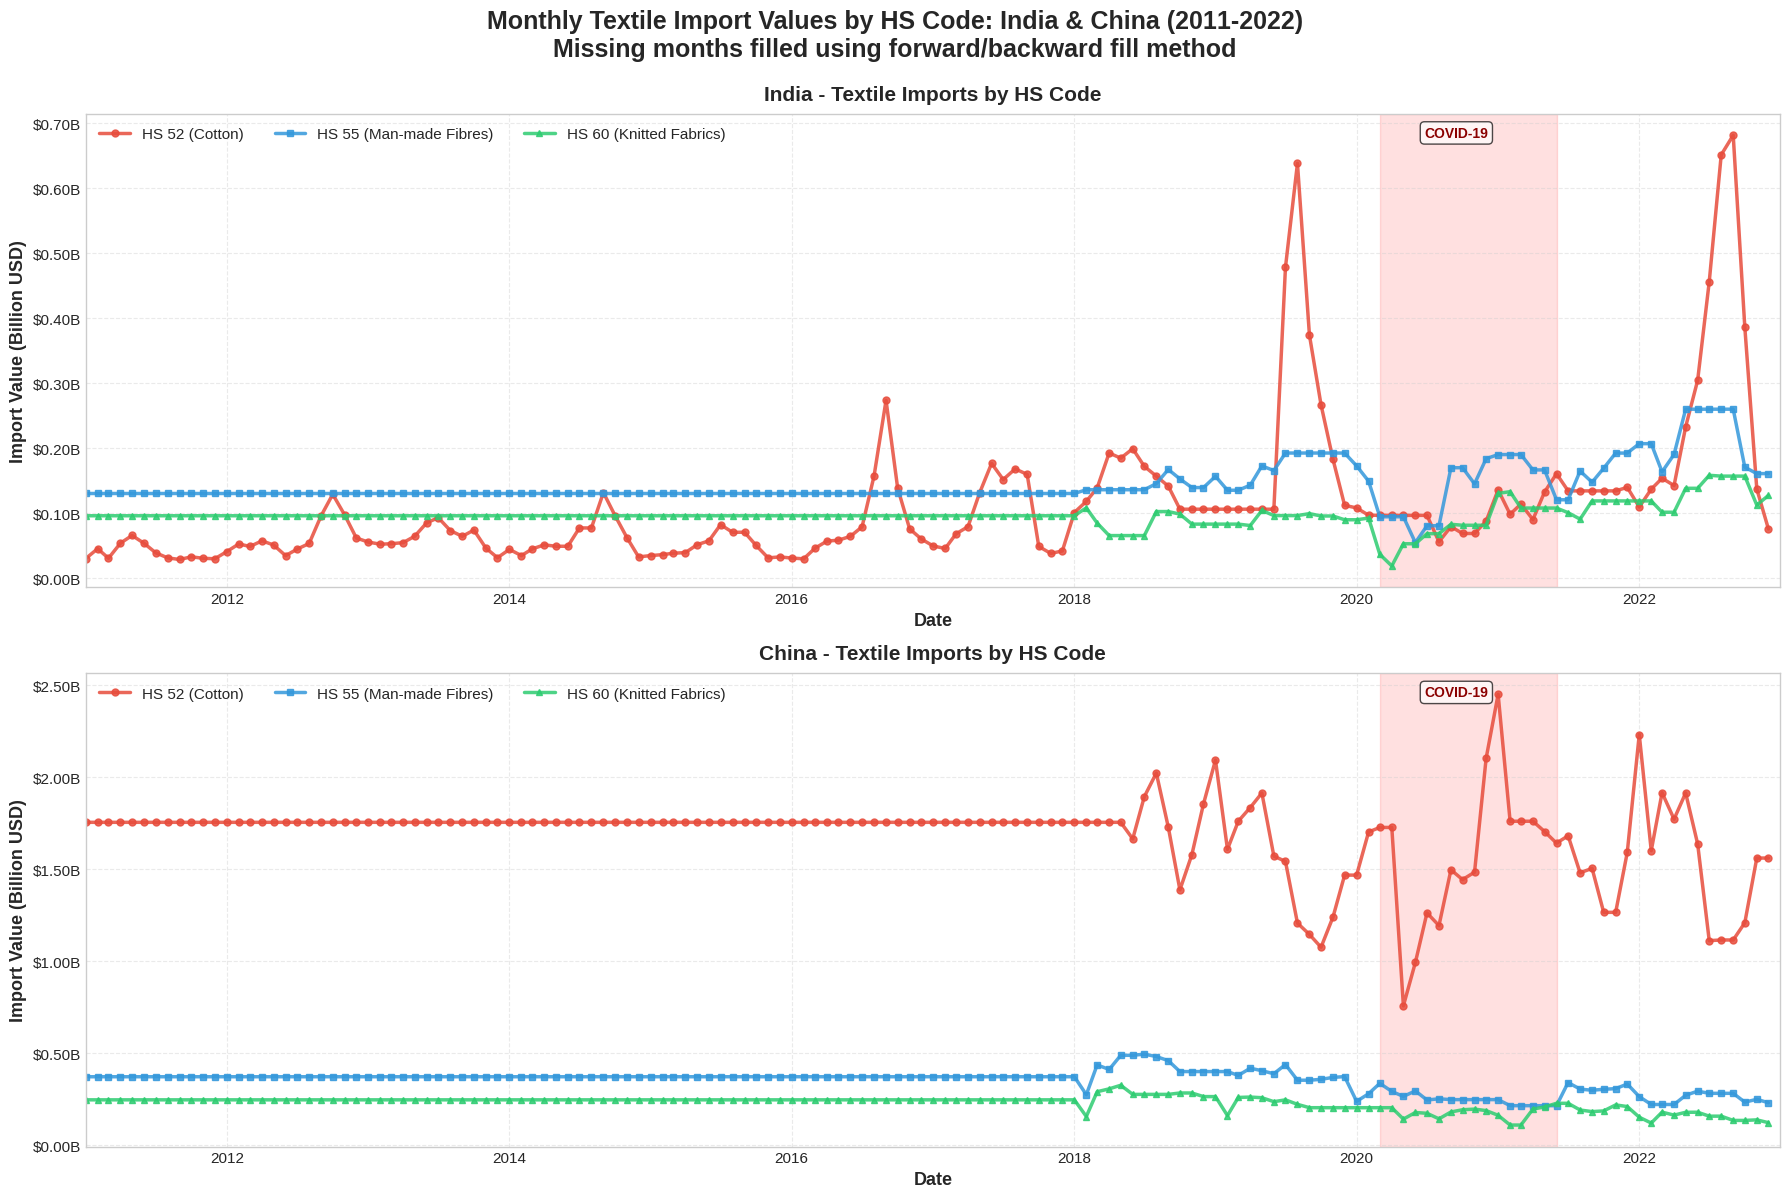

In [13]:
print("CREATING FIGURE 1: HS-LEVEL TIME SERIES")


fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig.suptitle(
    "Monthly Textile Import Values by HS Code: India & China (2011-2022)\n"
    + "Missing months filled using forward/backward fill method",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

colors_hs = {52: "#e74c3c", 55: "#3498db", 60: "#2ecc71"}
markers = {52: "o", 55: "s", 60: "^"}
hs_names = {
    52: "HS 52 (Cotton)",
    55: "HS 55 (Man-made Fibres)",
    60: "HS 60 (Knitted Fabrics)",
}

for idx, country in enumerate(countries):
    ax = axes[idx]

    for hs in hs_codes:
        hs_data = imports_complete[
            (imports_complete["reporter_name"] == country)
            & (imports_complete["hs_code"] == hs)
        ].sort_values("date")

        if len(hs_data) > 0:
            ax.plot(
                hs_data["date"],
                hs_data["primaryValue"] / 1e9,
                label=hs_names[hs],
                linewidth=2.5,
                marker=markers[hs],
                markersize=5,
                color=colors_hs[hs],
                alpha=0.85,
            )

    # Styling
    ax.set_title(
        f"{country} - Textile Imports by HS Code",
        fontsize=15,
        fontweight="bold",
        pad=10,
    )
    ax.set_xlabel("Date", fontsize=13, fontweight="bold")
    ax.set_ylabel("Import Value (Billion USD)", fontsize=13, fontweight="bold")
    ax.legend(loc="best", fontsize=11, framealpha=0.95, ncol=3)
    ax.grid(True, alpha=0.4, linestyle="--", linewidth=0.8)

    # COVID period
    ax.axvspan(
        pd.Timestamp("2020-03-01"),
        pd.Timestamp("2021-06-01"),
        alpha=0.12,
        color="red",
        zorder=0,
    )
    ax.text(
        pd.Timestamp("2020-09-15"),
        ax.get_ylim()[1] * 0.95,
        "COVID-19",
        fontsize=10,
        ha="center",
        color="darkred",
        fontweight="bold",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

    ax.set_xlim(pd.Timestamp("2011-01-01"), pd.Timestamp("2022-12-31"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:.2f}B"))
    ax.tick_params(axis="both", labelsize=11)

plt.tight_layout()
plt.savefig("Figure_1_HS_Level_Imports_Complete.png", dpi=300, bbox_inches="tight")
plt.show()

CREATING FIGURE 2: STACKED AREA COMPOSITION


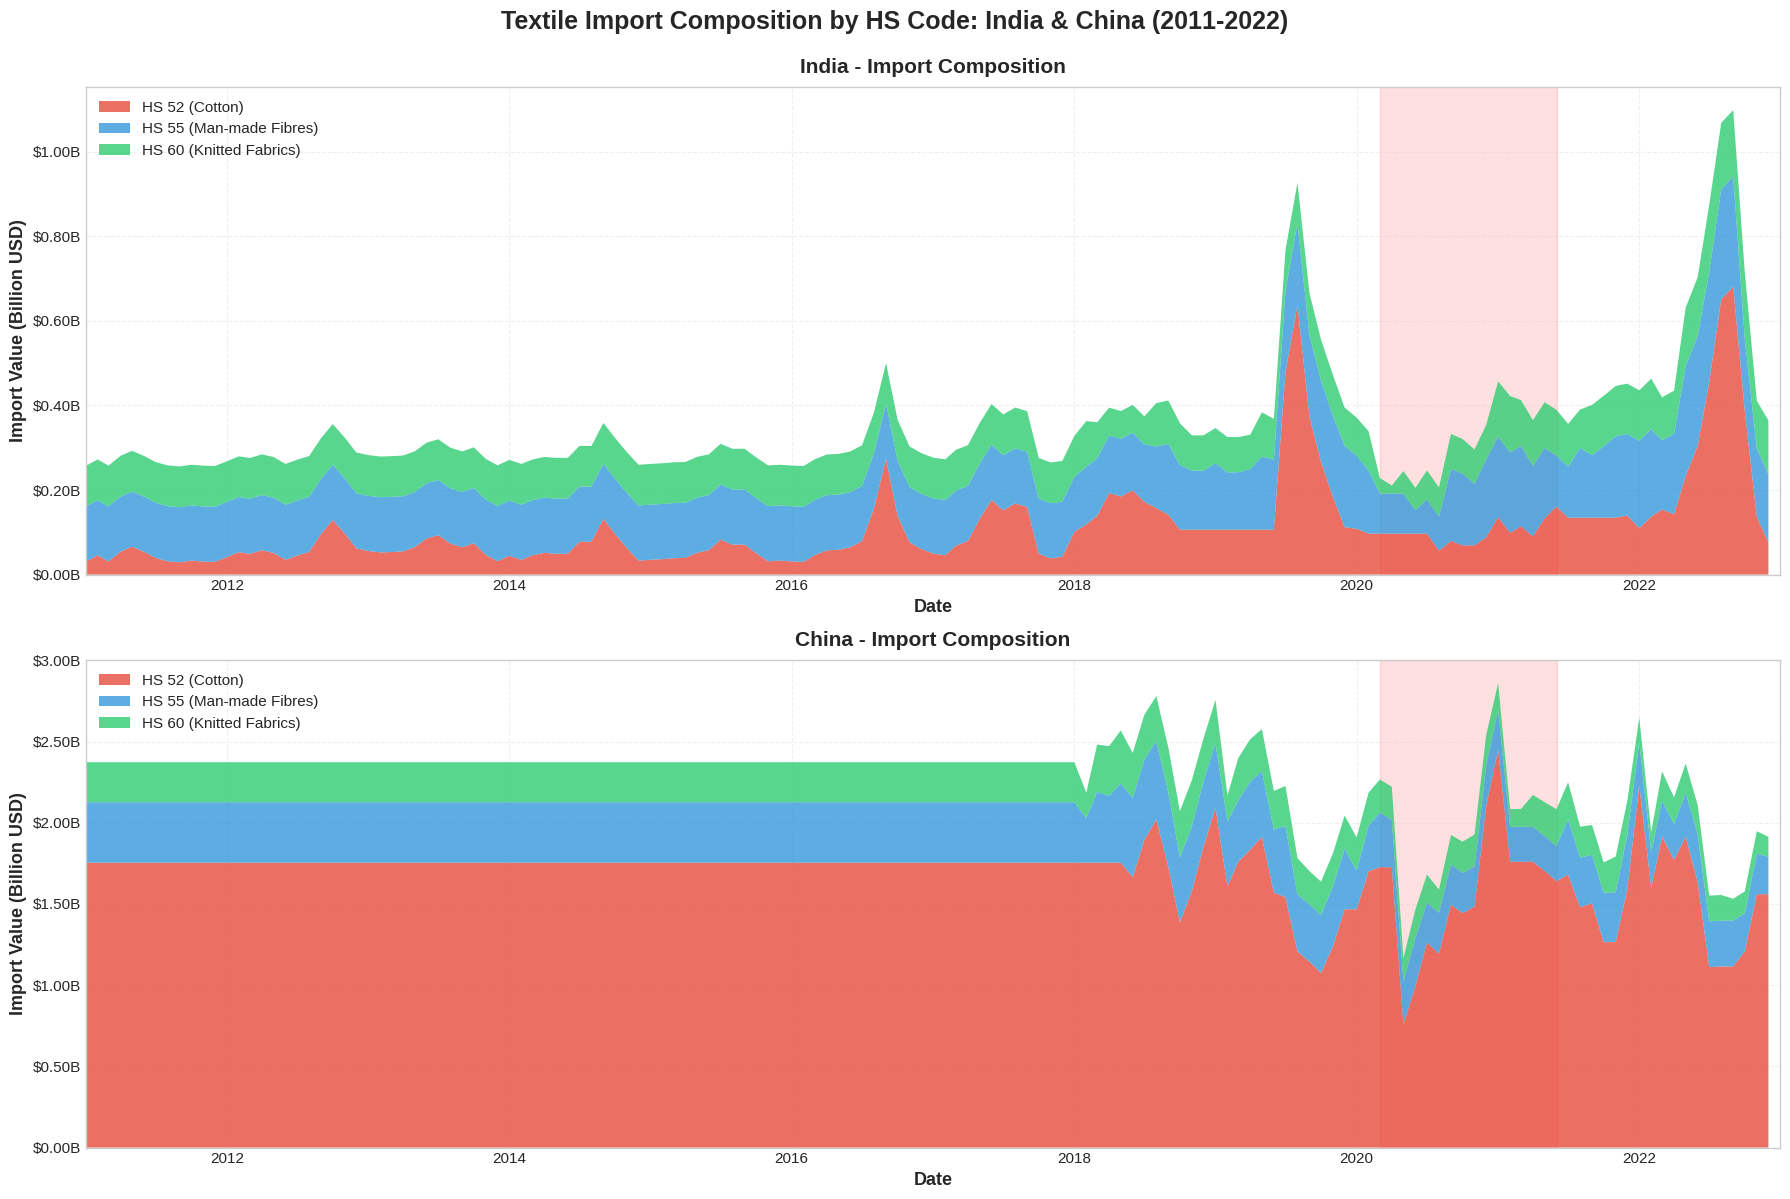

In [14]:
print("CREATING FIGURE 2: STACKED AREA COMPOSITION")


fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig.suptitle(
    "Textile Import Composition by HS Code: India & China (2011-2022)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

for idx, country in enumerate(countries):
    ax = axes[idx]

    # Pivot data
    pivot = (
        imports_complete[imports_complete["reporter_name"] == country]
        .pivot_table(
            index="date", columns="hs_code", values="primaryValue", aggfunc="sum"
        )
        .sort_index()
    )

    # Stacked area
    ax.stackplot(
        pivot.index,
        pivot[52] / 1e9,
        pivot[55] / 1e9,
        pivot[60] / 1e9,
        labels=[hs_names[52], hs_names[55], hs_names[60]],
        colors=[colors_hs[52], colors_hs[55], colors_hs[60]],
        alpha=0.8,
    )

    ax.set_title(
        f"{country} - Import Composition", fontsize=15, fontweight="bold", pad=10
    )
    ax.set_xlabel("Date", fontsize=13, fontweight="bold")
    ax.set_ylabel("Import Value (Billion USD)", fontsize=13, fontweight="bold")
    ax.legend(loc="upper left", fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle="--")

    # COVID period
    ax.axvspan(
        pd.Timestamp("2020-03-01"),
        pd.Timestamp("2021-06-01"),
        alpha=0.12,
        color="red",
        zorder=0,
    )

    ax.set_xlim(pd.Timestamp("2011-01-01"), pd.Timestamp("2022-12-31"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:.2f}B"))
    ax.tick_params(axis="both", labelsize=11)

plt.tight_layout()
plt.savefig("Figure_2_HS_Stacked_Area.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
print("CREATING SUMMARY TABLE")


summary = (
    imports_complete.groupby(["reporter_name", "hs_code"])
    .agg({"primaryValue": ["count", "sum", "mean", "std", "min", "max"]})
    .round(2)
)

summary.columns = ["Months", "Total_USD", "Mean_USD", "Std_USD", "Min_USD", "Max_USD"]
summary["Total_Billion_USD"] = (summary["Total_USD"] / 1e9).round(2)
summary["Mean_Million_USD"] = (summary["Mean_USD"] / 1e6).round(2)

print("\n" + summary.to_string())

summary.to_csv("Table_1_HS_Level_Summary.csv")

CREATING SUMMARY TABLE

                       Months     Total_USD      Mean_USD       Std_USD       Min_USD       Max_USD  Total_Billion_USD  Mean_Million_USD
reporter_name hs_code                                                                                                                   
China         52          144  2.426600e+11  1.685139e+09  2.204982e+08  7.575232e+08  2.449446e+09             242.66           1685.14
              55          144  5.047369e+10  3.505118e+08  5.915359e+07  2.150064e+08  4.949364e+08              50.47            350.51
              60          144  3.298350e+10  2.290521e+08  3.968533e+07  1.097951e+08  3.259470e+08              32.98            229.05
India         52          144  1.606564e+10  1.115669e+08  1.101724e+08  2.900414e+07  6.812782e+08              16.07            111.57
              55          144  2.078657e+10  1.443512e+08  3.270606e+07  5.490103e+07  2.600636e+08              20.79            144.35
              60 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools
import warnings


# Define metrics manually
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


warnings.filterwarnings("ignore")

print("PART 2: SARIMAX MODEL DEVELOPMENT")

# Load complete data
imports_complete = pd.read_csv("imports_hs_level_complete.csv")
imports_complete["date"] = pd.to_datetime(imports_complete["date"])

print(f"\n✓ Loaded: {len(imports_complete)} records")

PART 2: SARIMAX MODEL DEVELOPMENT

✓ Loaded: 864 records


In [17]:
# Dynamic split based on data length
# Total months = 12 years * 12 months = 144 months
# Test set = Last 12 months (2022)
# Train set = 132 months (2011-2021)

test_len = 12
train_size = len(imports_complete["date"].unique()) - test_len

print(f"New Training Size: {train_size} months (2011-2021)")
print(f"New Testing Size: {test_len} months (2022)")

New Training Size: 132 months (2011-2021)
New Testing Size: 12 months (2022)


In [18]:
def build_sarimax_model(data, country, hs_code, train_size=132):
    """
    Build and forecast SARIMAX model for a specific country-HS combination
    """
    print(f"SARIMAX: {country} - HS {hs_code}")

    # Filter data
    series_data = (
        data[(data["reporter_name"] == country) & (data["hs_code"] == hs_code)]
        .sort_values("date")
        .copy()
    )

    # Set date as index
    series_data = series_data.set_index("date")

    # Dependent variable
    y = series_data["primaryValue"]

    # Exogenous variables
    exog_cols = [
        "cotton_ppi",
        "textile_ppi",
        "usd_cny",
        "gdp_growth",
        "industrial_prod",
    ]
    exog = series_data[exog_cols]

    # Train-test split
    y_train = y[:train_size]
    y_test = y[train_size:]
    exog_train = exog[:train_size]
    exog_test = exog[train_size:]

    print(f"\nTrain: {len(y_train)} months | Test: {len(y_test)} months")

    # ════════════════════════════════════════════════════════════
    # Stationarity Test
    # ════════════════════════════════════════════════════════════
    print(f"\nStationarity Test (ADF):")
    adf_result = adfuller(y_train.dropna())
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")

    if adf_result[1] < 0.05:
        print(f"   Series is stationary")
        d_value = 0
    else:
        print(f"   Series is non-stationary, will use d=1")
        d_value = 1

    # ════════════════════════════════════════════════════════════
    # Grid Search for Best Parameters
    # ════════════════════════════════════════════════════════════
    print(f"\nGrid Search for Optimal Parameters...")

    # Parameter ranges (limited for speed)
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = 12  # Monthly seasonality

    pdq = list(itertools.product(p, [d_value], q))[:9]  # Limit combinations
    seasonal_pdq = list(itertools.product(P, [1], Q, [s]))[:4]

    best_aic = np.inf
    best_params = None
    best_seasonal = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(
                    y_train,
                    exog=exog_train,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )

                results = model.fit(disp=False, maxiter=200)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal = param_seasonal

            except:
                continue

    print(f"\n Best Model: SARIMAX{best_params}x{best_seasonal}")
    print(f"  AIC: {best_aic:.2f}")

    # ════════════════════════════════════════════════════════════
    # Fit Best Model
    # ════════════════════════════════════════════════════════════
    print(f"\nFitting best model...")

    best_model = SARIMAX(
        y_train,
        exog=exog_train,
        order=best_params,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    best_fit = best_model.fit(disp=False, maxiter=200)

    # ════════════════════════════════════════════════════════════
    # Forecasting
    # ════════════════════════════════════════════════════════════
    print(f"\nForecasting on test set...")

    forecast = best_fit.forecast(steps=len(y_test), exog=exog_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mae = mean_absolute_error(y_test, forecast)
    mape = mean_absolute_percentage_error(y_test, forecast) * 100

    print(f"\nPerformance Metrics:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE: ${mae:,.0f}")
    print(f"  MAPE: {mape:.2f}%")

    # Return results
    return {
        "country": country,
        "hs_code": hs_code,
        "model": best_fit,
        "order": best_params,
        "seasonal_order": best_seasonal,
        "aic": best_aic,
        "y_test": y_test,
        "forecast": forecast,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "dates_test": y_test.index,
    }

In [19]:
print("BUILDING SARIMAX MODELS FOR ALL HS CODES")


countries = ["India", "China"]
hs_codes = [52, 55, 60]
sarimax_results = []

for country in countries:
    for hs in hs_codes:
        result = build_sarimax_model(
            imports_complete, country, hs, train_size=train_size
        )
        sarimax_results.append(result)

BUILDING SARIMAX MODELS FOR ALL HS CODES
SARIMAX: India - HS 52

Train: 132 months | Test: 12 months

Stationarity Test (ADF):
  ADF Statistic: -3.4429
  p-value: 0.0096
   Series is stationary

Grid Search for Optimal Parameters...

 Best Model: SARIMAX(1, 0, 2)x(1, 1, 1, 12)
  AIC: 4086.92

Fitting best model...

Forecasting on test set...

Performance Metrics:
  RMSE: $257,043,152
  MAE: $178,945,401
  MAPE: 4705.39%
SARIMAX: India - HS 55

Train: 132 months | Test: 12 months

Stationarity Test (ADF):
  ADF Statistic: -1.1316
  p-value: 0.7023
   Series is non-stationary, will use d=1

Grid Search for Optimal Parameters...

 Best Model: SARIMAX(2, 1, 2)x(1, 1, 1, 12)
  AIC: 3746.40

Fitting best model...

Forecasting on test set...

Performance Metrics:
  RMSE: $141,685,937
  MAE: $120,477,270
  MAPE: 5314.67%
SARIMAX: India - HS 60

Train: 132 months | Test: 12 months

Stationarity Test (ADF):
  ADF Statistic: -2.5039
  p-value: 0.1145
   Series is non-stationary, will use d=1

Gri

In [20]:
# Create summary DataFrame
sarimax_summary = pd.DataFrame(
    [
        {
            "Country": r["country"],
            "HS_Code": r["hs_code"],
            "Order": str(r["order"]),
            "Seasonal_Order": str(r["seasonal_order"]),
            "AIC": r["aic"],
            "RMSE": r["rmse"],
            "MAE": r["mae"],
            "MAPE": r["mape"],
        }
        for r in sarimax_results
    ]
)

print("\n" + sarimax_summary.to_string(index=False))


Country  HS_Code     Order Seasonal_Order         AIC         RMSE          MAE        MAPE
  India       52 (1, 0, 2)  (1, 1, 1, 12) 4086.917493 2.570432e+08 1.789454e+08 4705.388324
  India       55 (2, 1, 2)  (1, 1, 1, 12) 3746.400669 1.416859e+08 1.204773e+08 5314.667294
  India       60 (0, 1, 2)  (1, 1, 1, 12) 3653.784093 5.399881e+07 4.704850e+07 3724.067758
  China       52 (2, 1, 2)  (1, 1, 1, 12) 4192.270057 7.608964e+08 7.237540e+08 4885.334095
  China       55 (1, 1, 2)  (1, 1, 1, 12) 3913.061562 1.805881e+08 1.659651e+08 6530.318043
  China       60 (0, 1, 2)  (0, 1, 1, 12) 3834.328989 9.323879e+07 8.603743e+07 5726.800921


In [21]:
sarimax_summary.to_csv("SARIMAX_Model_Summary.csv", index=False)

# Save detailed forecasts
all_forecasts = []
for r in sarimax_results:
    forecast_df = pd.DataFrame(
        {
            "date": r["dates_test"],
            "country": r["country"],
            "hs_code": r["hs_code"],
            "actual": r["y_test"].values,
            "sarimax_forecast": r["forecast"].values,
        }
    )
    all_forecasts.append(forecast_df)

forecasts_df = pd.concat(all_forecasts, ignore_index=True)
forecasts_df.to_csv("SARIMAX_Forecasts.csv", index=False)

CREATING FORECAST VISUALIZATIONS


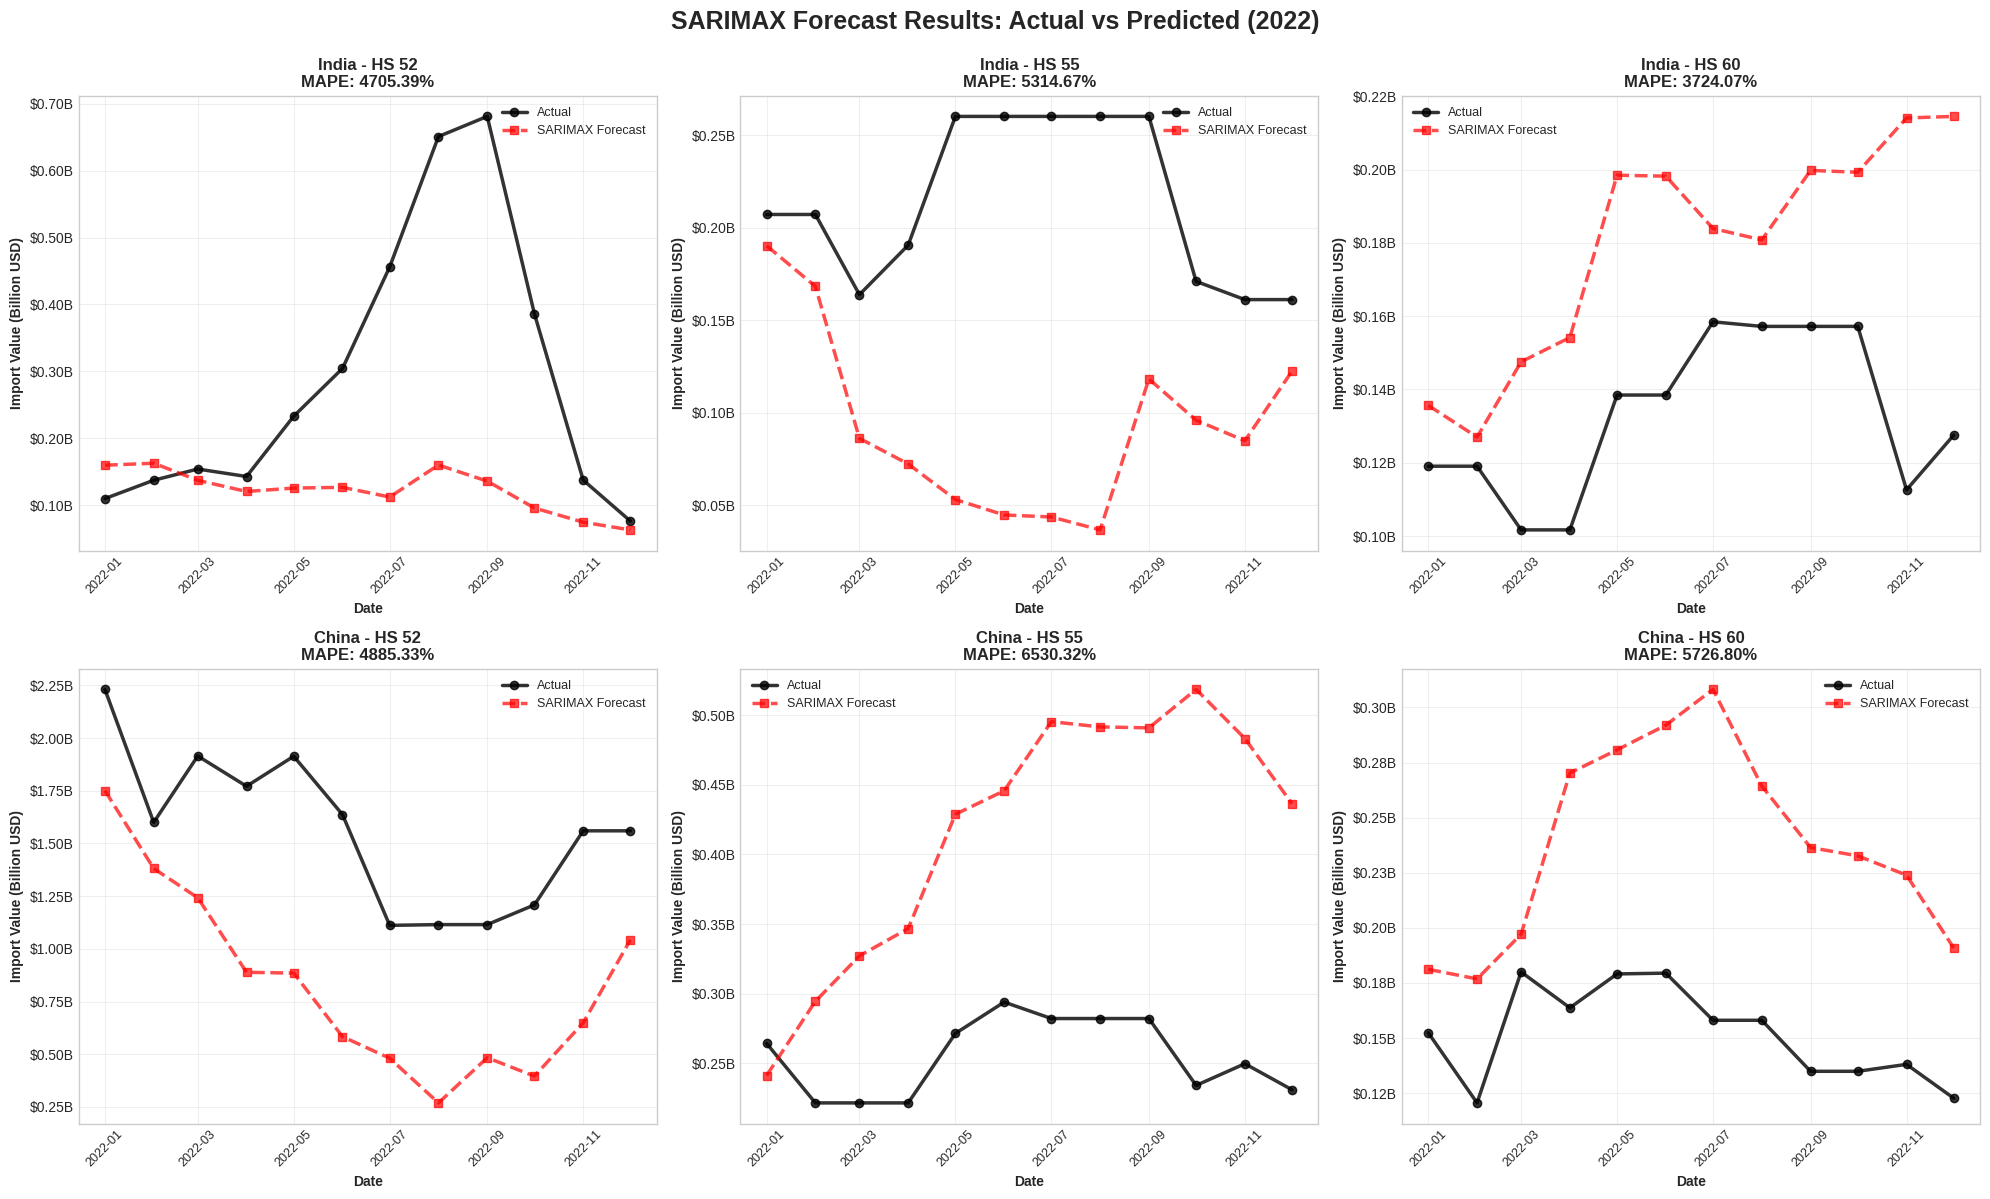

In [22]:
print("CREATING FORECAST VISUALIZATIONS")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "SARIMAX Forecast Results: Actual vs Predicted (2022)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

axes = axes.flatten()

for idx, r in enumerate(sarimax_results):
    ax = axes[idx]

    # Plot actual vs forecast
    ax.plot(
        r["dates_test"],
        r["y_test"] / 1e9,
        marker="o",
        markersize=6,
        linewidth=2.5,
        label="Actual",
        color="black",
        alpha=0.8,
    )

    ax.plot(
        r["dates_test"],
        r["forecast"] / 1e9,
        marker="s",
        markersize=6,
        linewidth=2.5,
        label="SARIMAX Forecast",
        color="red",
        alpha=0.7,
        linestyle="--",
    )

    # Title and labels
    ax.set_title(
        f"{r['country']} - HS {r['hs_code']}\n" + f"MAPE: {r['mape']:.2f}%",
        fontsize=12,
        fontweight="bold",
    )
    ax.set_xlabel("Date", fontsize=10, fontweight="bold")
    ax.set_ylabel("Import Value (Billion USD)", fontsize=10, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:.2f}B"))
    ax.tick_params(axis="x", rotation=45, labelsize=9)

plt.tight_layout()
plt.savefig("Figure_SARIMAX_Forecasts.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import warnings


# Define metrics manually
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


warnings.filterwarnings("ignore")

print("PART 2: SARIMAX MODEL DEVELOPMENT")

# Load complete data
imports_complete = pd.read_csv("imports_hs_level_complete.csv")
imports_complete["date"] = pd.to_datetime(imports_complete["date"])

print(f"\n✓ Loaded: {len(imports_complete)} records")

warnings.filterwarnings("ignore")


print("PART 3: XGBOOST MODEL DEVELOPMENT")


# Load complete data
imports_complete = pd.read_csv("imports_hs_level_complete.csv")
imports_complete["date"] = pd.to_datetime(imports_complete["date"])

print(f"\n✓ Loaded: {len(imports_complete)} records")

PART 2: SARIMAX MODEL DEVELOPMENT

✓ Loaded: 864 records
PART 3: XGBOOST MODEL DEVELOPMENT

✓ Loaded: 864 records


In [24]:
def create_features(data):
    """
    Create time-series features for XGBoost
    """
    df = data.copy()

    # Sort by date
    df = df.sort_values("date")

    # Time-based features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["day_of_year"] = df["date"].dt.dayofyear

    # Cyclical encoding for month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Trend feature
    df["trend"] = range(len(df))

    # Group by country-HS for lag features
    for country in df["reporter_name"].unique():
        for hs in df["hs_code"].unique():
            mask = (df["reporter_name"] == country) & (df["hs_code"] == hs)
            subset = df[mask].copy()

            if len(subset) > 0:
                # Lag features
                df.loc[mask, "lag_1"] = subset["primaryValue"].shift(1)
                df.loc[mask, "lag_3"] = subset["primaryValue"].shift(3)
                df.loc[mask, "lag_6"] = subset["primaryValue"].shift(6)
                df.loc[mask, "lag_12"] = subset["primaryValue"].shift(12)

                # Rolling features
                df.loc[mask, "rolling_mean_3"] = (
                    subset["primaryValue"].rolling(window=3).mean()
                )
                df.loc[mask, "rolling_mean_6"] = (
                    subset["primaryValue"].rolling(window=6).mean()
                )
                df.loc[mask, "rolling_std_3"] = (
                    subset["primaryValue"].rolling(window=3).std()
                )

    # Fill NaN from lag features
    df = df.fillna(method="bfill").fillna(method="ffill")

    return df


imports_features = create_features(imports_complete)

feature_cols = [
    "year",
    "month",
    "quarter",
    "month_sin",
    "month_cos",
    "trend",
    "lag_1",
    "lag_3",
    "lag_6",
    "lag_12",
    "rolling_mean_3",
    "rolling_mean_6",
    "rolling_std_3",
    "cotton_ppi",
    "textile_ppi",
    "usd_cny",
    "gdp_growth",
    "industrial_prod",
]

print(f"✓ Created {len(feature_cols)} features")
print(f"  Temporal: year, month, quarter, sin/cos encoding, trend")
print(f"  Lag: 1, 3, 6, 12 months")
print(f"  Rolling: 3-month mean, 6-month mean, 3-month std")
print(f"  Exogenous: cotton_ppi, textile_ppi, usd_cny, gdp_growth, industrial_prod")

✓ Created 18 features
  Temporal: year, month, quarter, sin/cos encoding, trend
  Lag: 1, 3, 6, 12 months
  Rolling: 3-month mean, 6-month mean, 3-month std
  Exogenous: cotton_ppi, textile_ppi, usd_cny, gdp_growth, industrial_prod


In [25]:
def build_xgboost_model(data, country, hs_code, train_size=132):
    """
    Build and forecast XGBoost model for a specific country-HS combination
    """
    print(f"\n{'='*70}")
    print(f"XGBOOST: {country} - HS {hs_code}")
    print(f"{'='*70}")

    # Filter data
    series_data = (
        data[(data["reporter_name"] == country) & (data["hs_code"] == hs_code)]
        .sort_values("date")
        .copy()
    )

    # Features and target
    X = series_data[feature_cols]
    y = series_data["primaryValue"]

    # Train-test split
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    print(f"\nTrain: {len(X_train)} months | Test: {len(X_test)} months")
    print(f"Features: {len(feature_cols)}")

    # ════════════════════════════════════════════════════════════
    # Train XGBoost Model (FIXED - no early_stopping_rounds)
    # ════════════════════════════════════════════════════════════
    print(f"\nTraining XGBoost model...")

    # XGBoost parameters (tuned for time-series)
    params = {
        "objective": "reg:squarederror",
        "max_depth": 4,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "n_jobs": -1,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)  # ← FIXED: Removed early_stopping_rounds

    # ════════════════════════════════════════════════════════════
    # Forecasting
    # ════════════════════════════════════════════════════════════
    print(f"\nForecasting on test set...")

    forecast = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mae = mean_absolute_error(y_test, forecast)
    mape = mean_absolute_percentage_error(y_test, forecast) * 100

    print(f"\nPerformance Metrics:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE: ${mae:,.0f}")
    print(f"  MAPE: {mape:.2f}%")

    # Feature importance
    feature_importance = pd.DataFrame(
        {"feature": feature_cols, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)

    print(f"\nTop 5 Features:")
    for idx, row in feature_importance.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Return results
    return {
        "country": country,
        "hs_code": hs_code,
        "model": model,
        "y_test": y_test,
        "forecast": forecast,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "dates_test": series_data["date"].iloc[train_size:].values,
        "feature_importance": feature_importance,
    }


# ════════════════════════════════════════════════════════════════
# BUILD MODELS FOR ALL COMBINATIONS
# ════════════════════════════════════════════════════════════════

print("BUILDING XGBOOST MODELS FOR ALL HS CODES")


countries = ["India", "China"]
hs_codes = [52, 55, 60]
xgboost_results = []

for country in countries:
    for hs in hs_codes:
        result = build_xgboost_model(
            imports_features, country, hs, train_size=train_size
        )
        xgboost_results.append(result)

BUILDING XGBOOST MODELS FOR ALL HS CODES

XGBOOST: India - HS 52

Train: 132 months | Test: 12 months
Features: 18

Training XGBoost model...

Forecasting on test set...

Performance Metrics:
  RMSE: $168,854,873
  MAE: $127,154,574
  MAPE: 4916.68%

Top 5 Features:
  rolling_mean_3: 0.2861
  rolling_std_3: 0.1909
  quarter: 0.1552
  lag_1: 0.1508
  cotton_ppi: 0.0544

XGBOOST: India - HS 55

Train: 132 months | Test: 12 months
Features: 18

Training XGBoost model...

Forecasting on test set...

Performance Metrics:
  RMSE: $57,555,164
  MAE: $48,944,425
  MAPE: 2161.40%

Top 5 Features:
  rolling_mean_3: 0.3702
  lag_1: 0.2728
  usd_cny: 0.0979
  lag_12: 0.0581
  industrial_prod: 0.0285

XGBOOST: India - HS 60

Train: 132 months | Test: 12 months
Features: 18

Training XGBoost model...

Forecasting on test set...

Performance Metrics:
  RMSE: $33,189,681
  MAE: $26,530,843
  MAPE: 1823.48%

Top 5 Features:
  rolling_mean_3: 0.3122
  rolling_mean_6: 0.1311
  gdp_growth: 0.1204
  indust

In [26]:
# Create summary DataFrame
xgboost_summary = pd.DataFrame(
    [
        {
            "Country": r["country"],
            "HS_Code": r["hs_code"],
            "RMSE": r["rmse"],
            "MAE": r["mae"],
            "MAPE": r["mape"],
        }
        for r in xgboost_results
    ]
)

print("\n" + xgboost_summary.to_string(index=False))

xgboost_summary.to_csv("XGBoost_Model_Summary.csv", index=False)


Country  HS_Code         RMSE          MAE        MAPE
  India       52 1.688549e+08 1.271546e+08 4916.682834
  India       55 5.755516e+07 4.894443e+07 2161.402291
  India       60 3.318968e+07 2.653084e+07 1823.481059
  China       52 2.682062e+08 2.307280e+08 1623.916646
  China       55 6.173183e+07 5.583513e+07 2322.197889
  China       60 6.180429e+07 5.807940e+07 4066.570732


In [27]:
# Save forecasts
all_forecasts = []
for r in xgboost_results:
    forecast_df = pd.DataFrame(
        {
            "date": r["dates_test"],
            "country": r["country"],
            "hs_code": r["hs_code"],
            "actual": r["y_test"].values,
            "xgboost_forecast": r["forecast"],
        }
    )
    all_forecasts.append(forecast_df)

forecasts_df = pd.concat(all_forecasts, ignore_index=True)
forecasts_df.to_csv("XGBoost_Forecasts.csv", index=False)

CREATING FORECAST VISUALIZATIONS


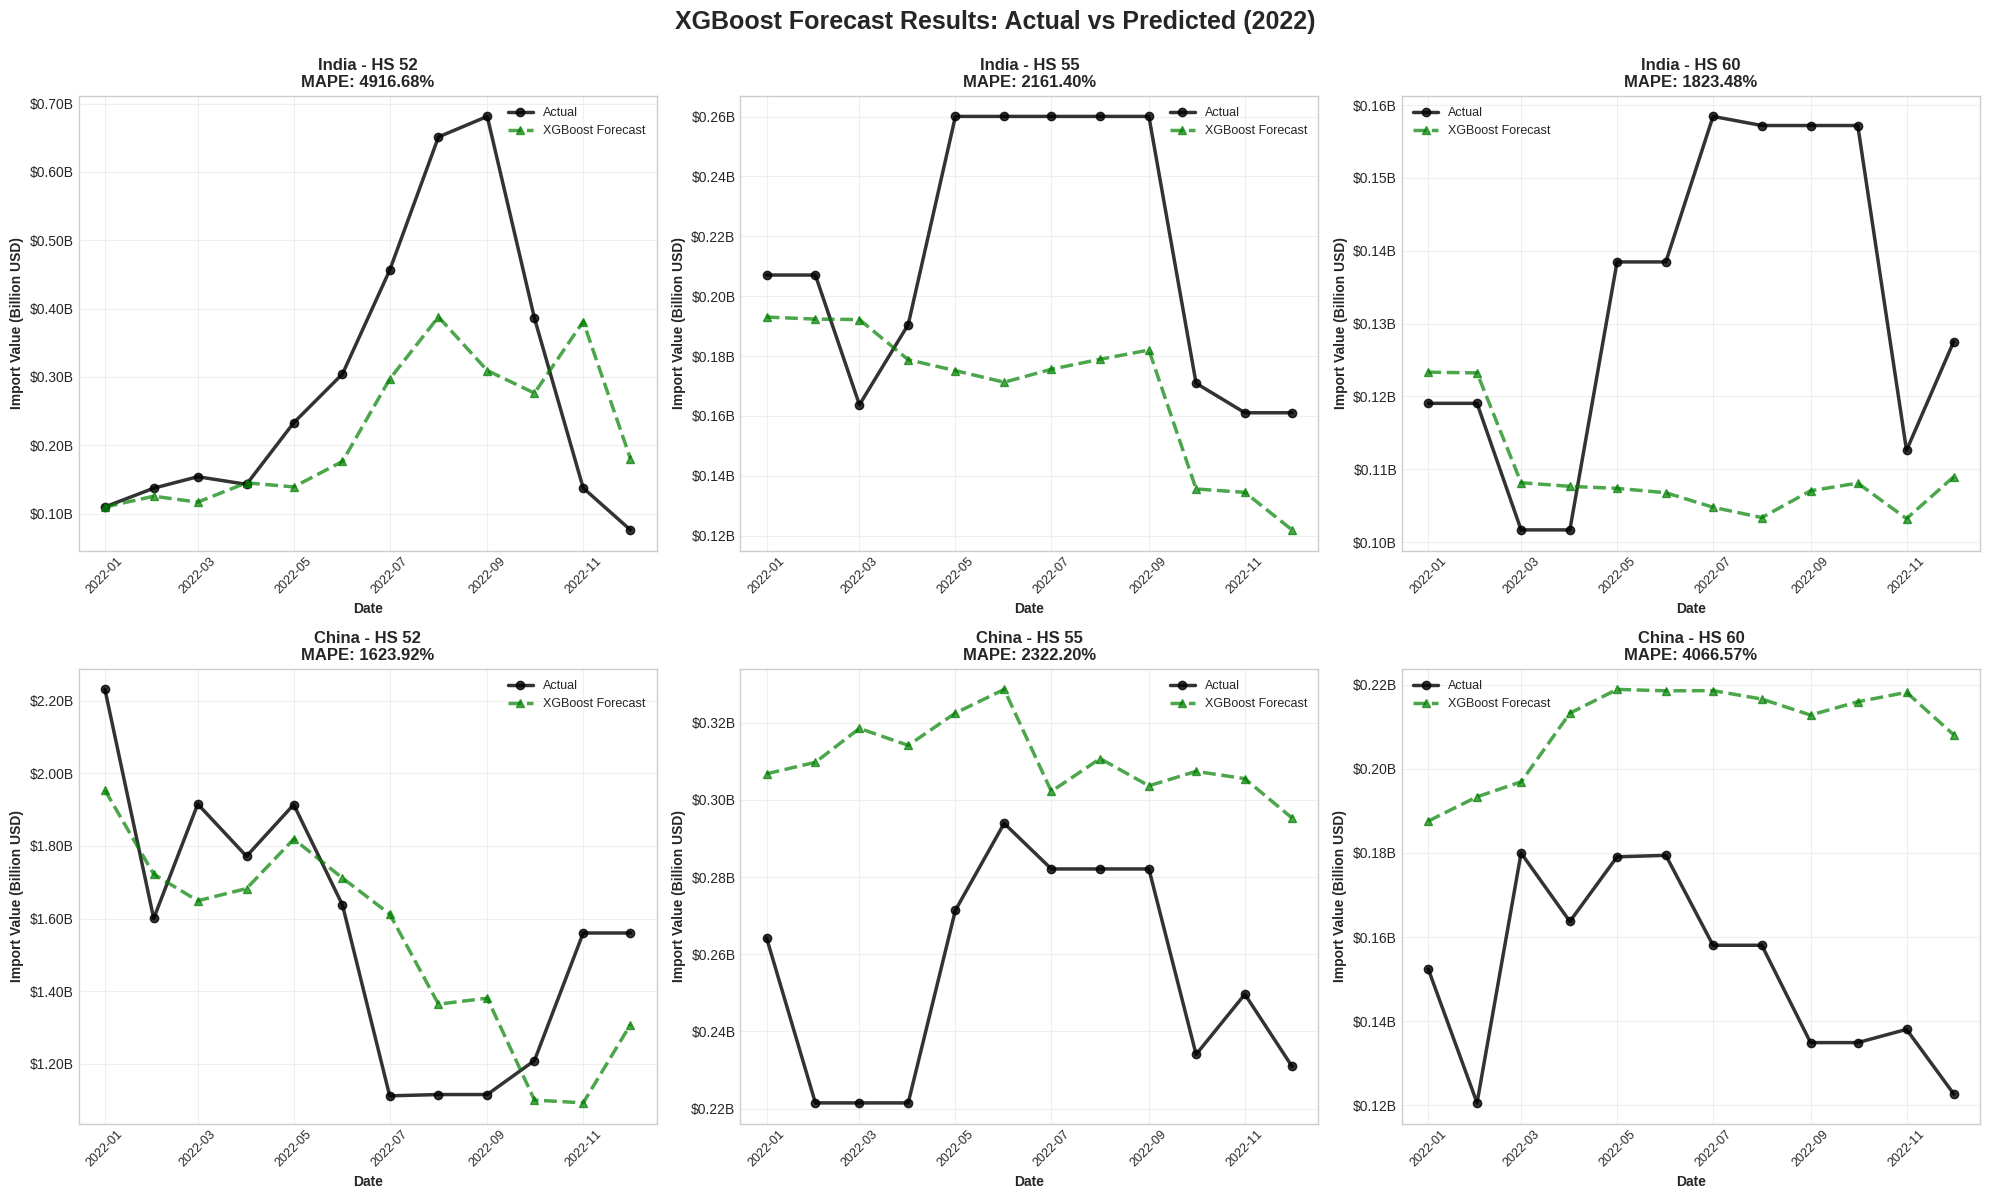

In [28]:
print("CREATING FORECAST VISUALIZATIONS")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "XGBoost Forecast Results: Actual vs Predicted (2022)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

axes = axes.flatten()

for idx, r in enumerate(xgboost_results):
    ax = axes[idx]

    # Plot actual vs forecast
    ax.plot(
        r["dates_test"],
        r["y_test"] / 1e9,
        marker="o",
        markersize=6,
        linewidth=2.5,
        label="Actual",
        color="black",
        alpha=0.8,
    )

    ax.plot(
        r["dates_test"],
        r["forecast"] / 1e9,
        marker="^",
        markersize=6,
        linewidth=2.5,
        label="XGBoost Forecast",
        color="green",
        alpha=0.7,
        linestyle="--",
    )

    # Title and labels
    ax.set_title(
        f"{r['country']} - HS {r['hs_code']}\n" + f"MAPE: {r['mape']:.2f}%",
        fontsize=12,
        fontweight="bold",
    )
    ax.set_xlabel("Date", fontsize=10, fontweight="bold")
    ax.set_ylabel("Import Value (Billion USD)", fontsize=10, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:.2f}B"))
    ax.tick_params(axis="x", rotation=45, labelsize=9)

plt.tight_layout()
plt.savefig("Figure_XGBoost_Forecasts.png", dpi=300, bbox_inches="tight")

plt.show()

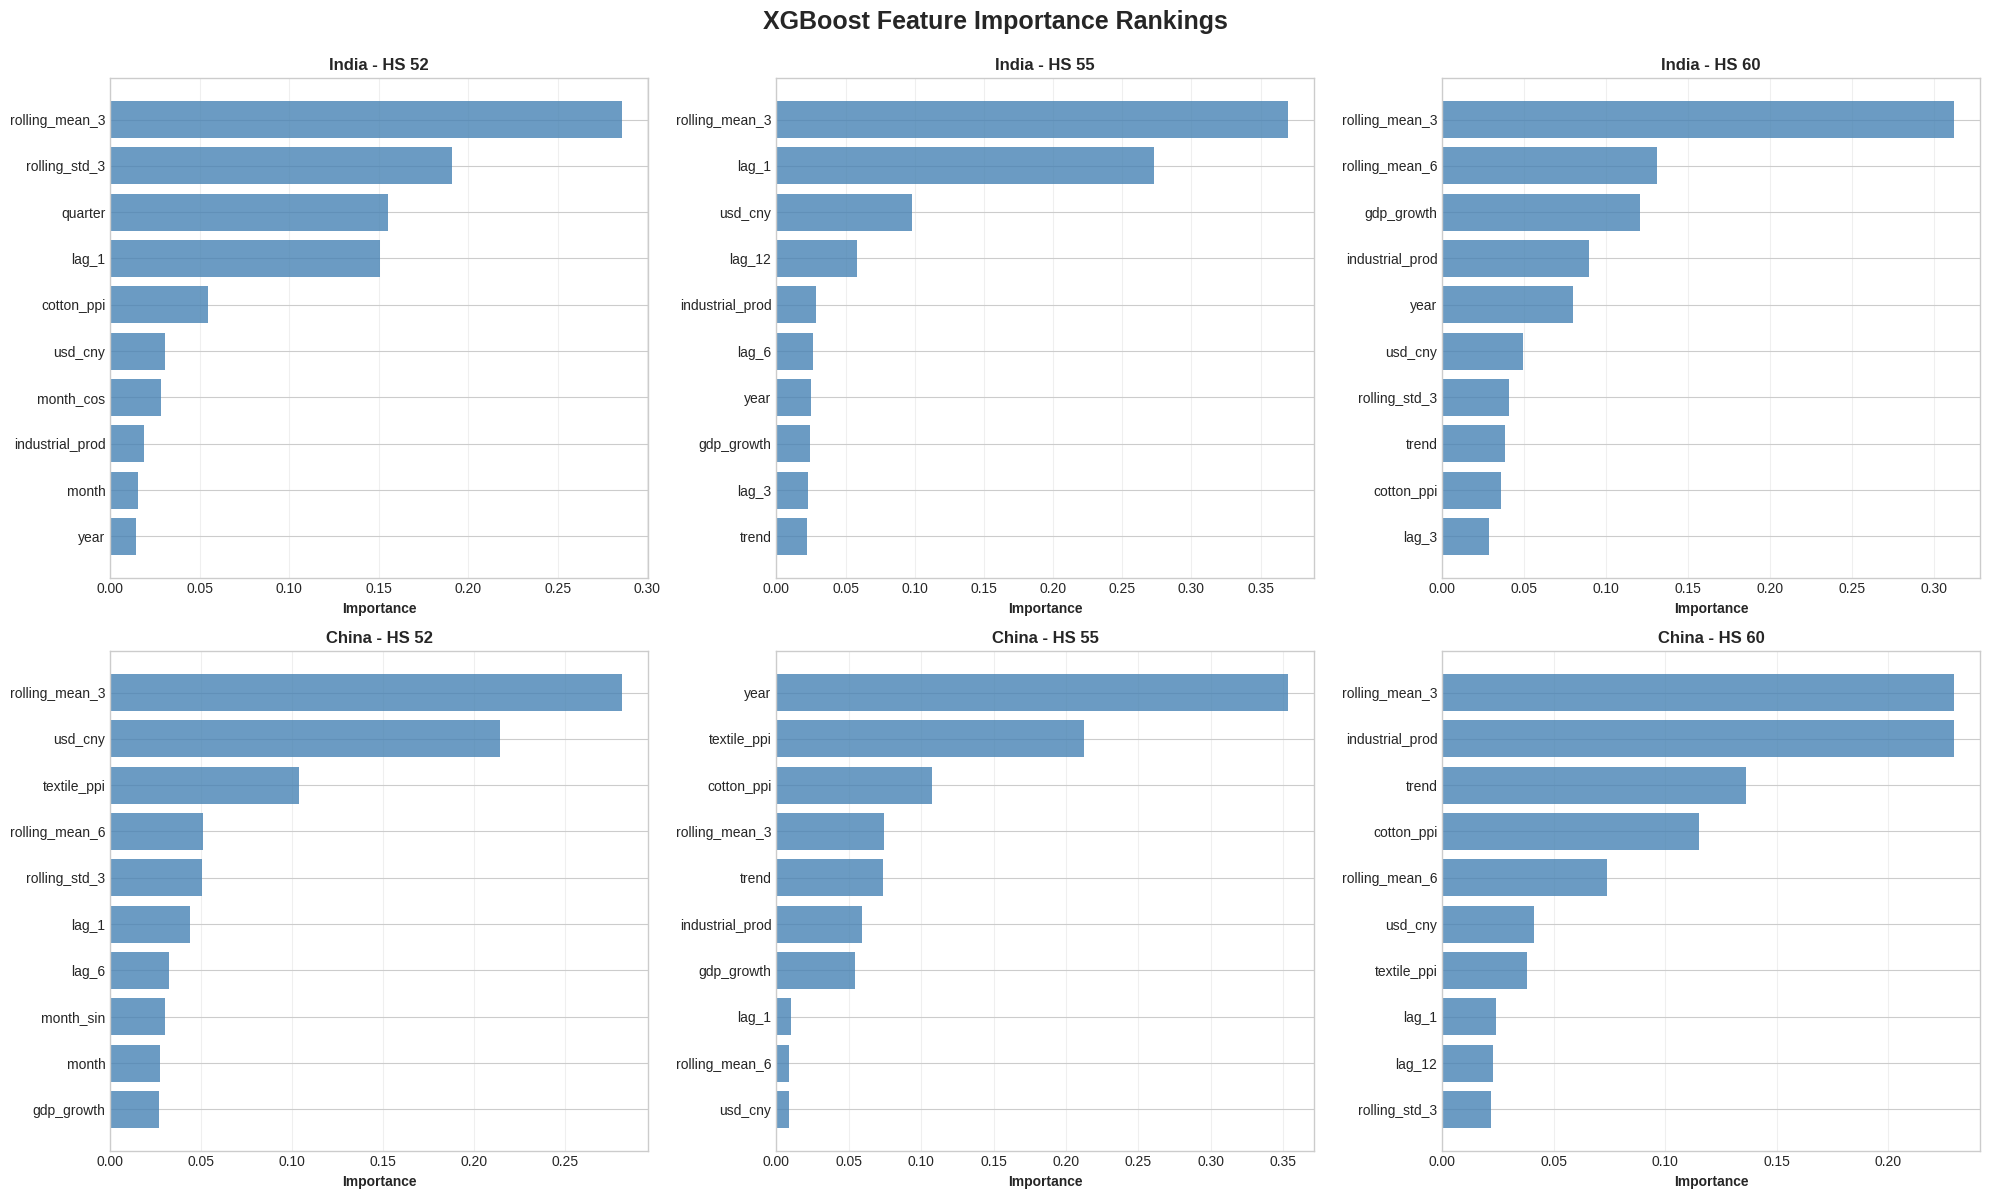

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "XGBoost Feature Importance Rankings", fontsize=18, fontweight="bold", y=0.995
)

axes = axes.flatten()

for idx, r in enumerate(xgboost_results):
    ax = axes[idx]

    top_features = r["feature_importance"].head(10)

    ax.barh(
        range(len(top_features)),
        top_features["importance"],
        color="steelblue",
        alpha=0.8,
    )
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features["feature"])
    ax.set_xlabel("Importance", fontsize=10, fontweight="bold")
    ax.set_title(f"{r['country']} - HS {r['hs_code']}", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="x")
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Figure_Feature_Importance.png", dpi=300, bbox_inches="tight")

plt.show()

In [30]:
sarimax_summary = pd.read_csv("SARIMAX_Model_Summary.csv")
xgboost_summary = pd.read_csv("XGBoost_Model_Summary.csv")

sarimax_forecasts = pd.read_csv("SARIMAX_Forecasts.csv")
xgboost_forecasts = pd.read_csv("XGBoost_Forecasts.csv")


# ════════════════════════════════════════════════════════════════
# MERGE RESULTS FOR COMPARISON
# ════════════════════════════════════════════════════════════════


# Merge summaries
comparison = pd.merge(
    sarimax_summary[["Country", "HS_Code", "MAPE"]],
    xgboost_summary[["Country", "HS_Code", "MAPE"]],
    on=["Country", "HS_Code"],
    suffixes=("_SARIMAX", "_XGBoost"),
)

# Calculate improvement
comparison["MAPE_Difference"] = comparison["MAPE_SARIMAX"] - comparison["MAPE_XGBoost"]
comparison["Better_Model"] = comparison["MAPE_Difference"].apply(
    lambda x: "XGBoost" if x > 0 else "SARIMAX"
)
comparison["Improvement_%"] = abs(comparison["MAPE_Difference"])

In [31]:
print("\n" + comparison.to_string(index=False))


Country  HS_Code  MAPE_SARIMAX  MAPE_XGBoost  MAPE_Difference Better_Model  Improvement_%
  India       52   4705.388324   4916.682834      -211.294511      SARIMAX     211.294511
  India       55   5314.667294   2161.402291      3153.265003      XGBoost    3153.265003
  India       60   3724.067758   1823.481059      1900.586699      XGBoost    1900.586699
  China       52   4885.334095   1623.916646      3261.417449      XGBoost    3261.417449
  China       55   6530.318043   2322.197889      4208.120154      XGBoost    4208.120154
  China       60   5726.800921   4066.570732      1660.230188      XGBoost    1660.230188


In [32]:
comparison.to_csv("Model_Comparison_Summary.csv", index=False)

In [33]:
print(f"\n{'MODEL PERFORMANCE SUMMARY':-^60}")
print(f"\nSARIMAX:")
print(f"  Average MAPE: {comparison['MAPE_SARIMAX'].mean():.2f}%")
print(f"  Std Dev: {comparison['MAPE_SARIMAX'].std():.2f}%")
print(
    f"  Best: {comparison['MAPE_SARIMAX'].min():.2f}% ({comparison.loc[comparison['MAPE_SARIMAX'].idxmin(), 'Country']} HS {comparison.loc[comparison['MAPE_SARIMAX'].idxmin(), 'HS_Code']})"
)
print(
    f"  Worst: {comparison['MAPE_SARIMAX'].max():.2f}% ({comparison.loc[comparison['MAPE_SARIMAX'].idxmax(), 'Country']} HS {comparison.loc[comparison['MAPE_SARIMAX'].idxmax(), 'HS_Code']})"
)


-----------------MODEL PERFORMANCE SUMMARY------------------

SARIMAX:
  Average MAPE: 5147.76%
  Std Dev: 955.62%
  Best: 3724.07% (India HS 60)
  Worst: 6530.32% (China HS 55)


In [34]:
print(f"\nXGBoost:")
print(f"  Average MAPE: {comparison['MAPE_XGBoost'].mean():.2f}%")
print(f"  Std Dev: {comparison['MAPE_XGBoost'].std():.2f}%")
print(
    f"  Best: {comparison['MAPE_XGBoost'].min():.2f}% ({comparison.loc[comparison['MAPE_XGBoost'].idxmin(), 'Country']} HS {comparison.loc[comparison['MAPE_XGBoost'].idxmin(), 'HS_Code']})"
)
print(
    f"  Worst: {comparison['MAPE_XGBoost'].max():.2f}% ({comparison.loc[comparison['MAPE_XGBoost'].idxmax(), 'Country']} HS {comparison.loc[comparison['MAPE_XGBoost'].idxmax(), 'HS_Code']})"
)


XGBoost:
  Average MAPE: 2819.04%
  Std Dev: 1345.75%
  Best: 1623.92% (China HS 52)
  Worst: 4916.68% (India HS 52)


In [35]:
xgboost_wins = (comparison["Better_Model"] == "XGBoost").sum()
sarimax_wins = (comparison["Better_Model"] == "SARIMAX").sum()

print(f"\n{'WIN COUNT':-^60}")
print(f"  XGBoost wins: {xgboost_wins} out of {len(comparison)} models")
print(f"  SARIMAX wins: {sarimax_wins} out of {len(comparison)} models")


-------------------------WIN COUNT--------------------------
  XGBoost wins: 5 out of 6 models
  SARIMAX wins: 1 out of 6 models


In [36]:
# Paired t-test
from scipy import stats

t_stat, p_value = stats.ttest_rel(
    comparison["MAPE_SARIMAX"], comparison["MAPE_XGBoost"]
)
print(f"\n{'PAIRED T-TEST':-^60}")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"  ✓ Statistically significant difference (p < 0.05)")
else:
    print(f"  ✗ No statistically significant difference (p ≥ 0.05)")


-----------------------PAIRED T-TEST------------------------
  t-statistic: 3.6572
  p-value: 0.0146
  ✓ Statistically significant difference (p < 0.05)


CREATING COMPARISON VISUALIZATIONS


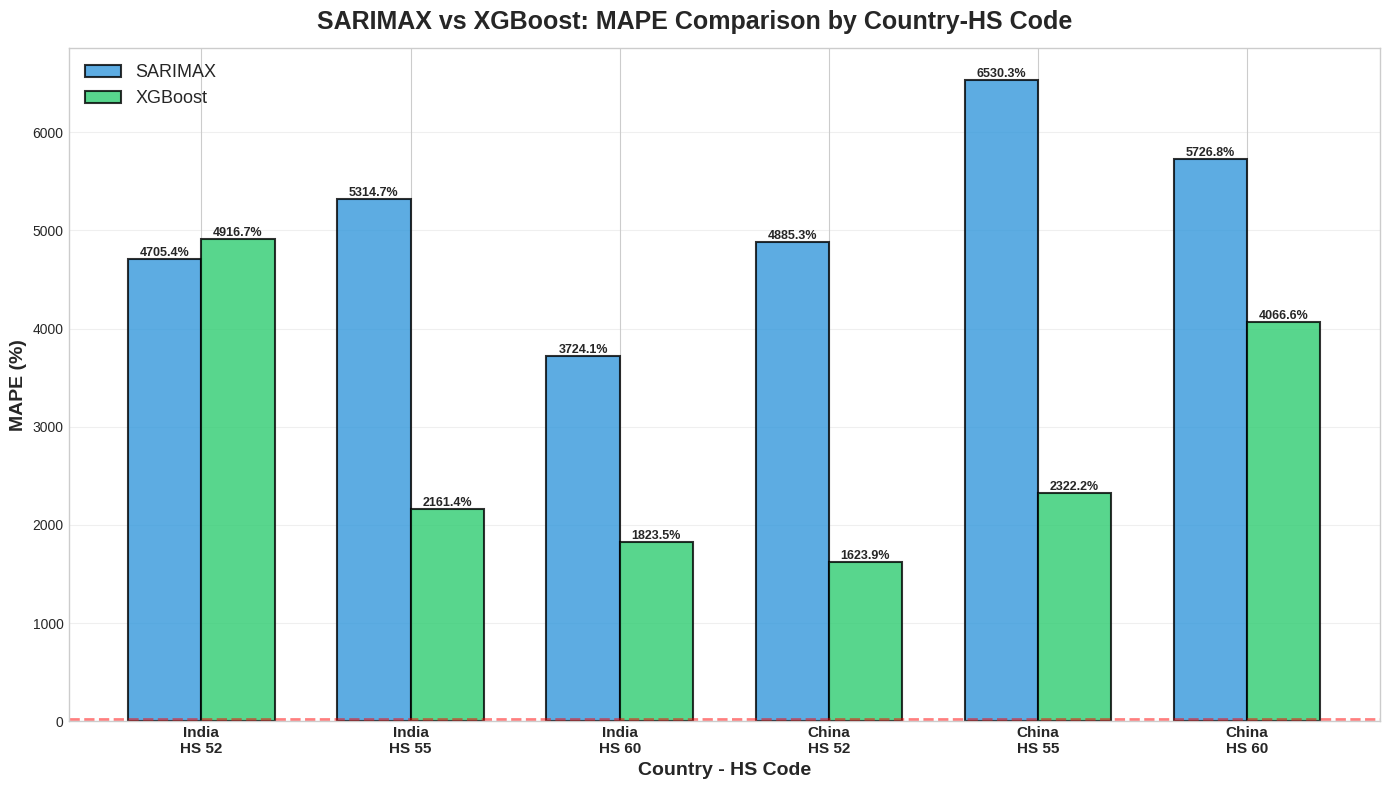

In [37]:
print("CREATING COMPARISON VISUALIZATIONS")


fig, ax = plt.subplots(1, 1, figsize=(14, 8))
fig.suptitle(
    "SARIMAX vs XGBoost: MAPE Comparison by Country-HS Code",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

x = np.arange(len(comparison))
width = 0.35

bars1 = ax.bar(
    x - width / 2,
    comparison["MAPE_SARIMAX"],
    width,
    label="SARIMAX",
    color="#3498db",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)
bars2 = ax.bar(
    x + width / 2,
    comparison["MAPE_XGBoost"],
    width,
    label="XGBoost",
    color="#2ecc71",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)

# Labels
labels = [f"{row['Country']}\nHS {row['HS_Code']}" for _, row in comparison.iterrows()]
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, fontweight="bold")
ax.set_ylabel("MAPE (%)", fontsize=14, fontweight="bold")
ax.set_xlabel("Country - HS Code", fontsize=14, fontweight="bold")
ax.legend(fontsize=13, loc="upper left", framealpha=0.95)
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

# Horizontal line at 20% (good performance threshold)
ax.axhline(
    y=20, color="red", linestyle="--", linewidth=2, alpha=0.5, label="20% Threshold"
)

plt.tight_layout()
plt.savefig("Figure_Model_Comparison_MAPE.png", dpi=300, bbox_inches="tight")

plt.show()

CREATING COMBINED FORECAST PLOTS


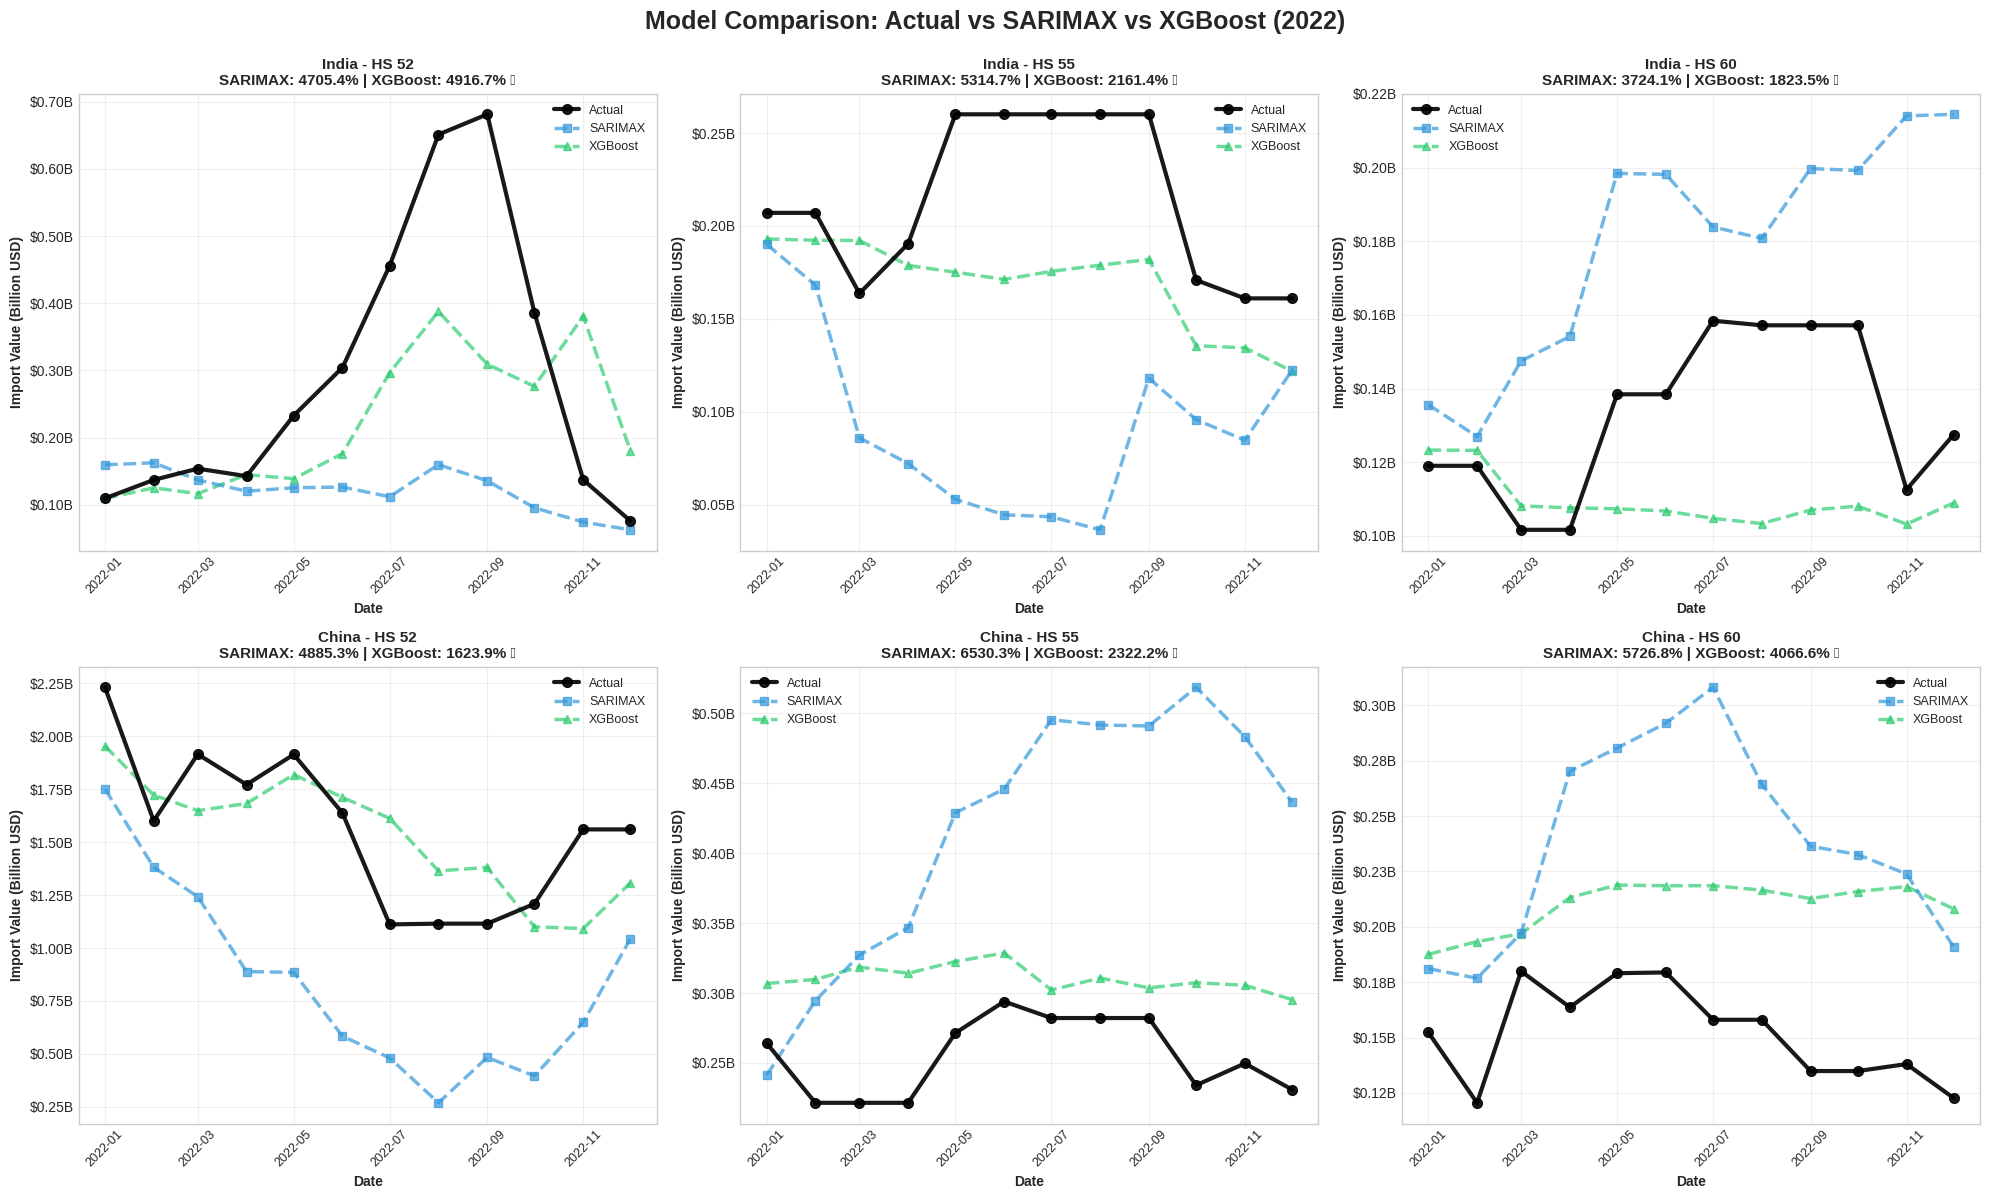

In [38]:
print("CREATING COMBINED FORECAST PLOTS")


# Merge forecasts
combined_forecasts = pd.merge(
    sarimax_forecasts,
    xgboost_forecasts[["date", "country", "hs_code", "xgboost_forecast"]],
    on=["date", "country", "hs_code"],
)
combined_forecasts["date"] = pd.to_datetime(combined_forecasts["date"])

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "Model Comparison: Actual vs SARIMAX vs XGBoost (2022)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

axes = axes.flatten()

countries = ["India", "China"]
hs_codes = [52, 55, 60]
idx = 0

for country in countries:
    for hs in hs_codes:
        ax = axes[idx]

        data = combined_forecasts[
            (combined_forecasts["country"] == country)
            & (combined_forecasts["hs_code"] == hs)
        ].sort_values("date")

        # Plot
        ax.plot(
            data["date"],
            data["actual"] / 1e9,
            marker="o",
            markersize=7,
            linewidth=3,
            label="Actual",
            color="black",
            alpha=0.9,
            zorder=3,
        )

        ax.plot(
            data["date"],
            data["sarimax_forecast"] / 1e9,
            marker="s",
            markersize=6,
            linewidth=2.5,
            label="SARIMAX",
            color="#3498db",
            alpha=0.7,
            linestyle="--",
            zorder=2,
        )

        ax.plot(
            data["date"],
            data["xgboost_forecast"] / 1e9,
            marker="^",
            markersize=6,
            linewidth=2.5,
            label="XGBoost",
            color="#2ecc71",
            alpha=0.7,
            linestyle="--",
            zorder=1,
        )

        # Get MAPE values
        comp_row = comparison[
            (comparison["Country"] == country) & (comparison["HS_Code"] == hs)
        ].iloc[0]

        winner = comp_row["Better_Model"]
        winner_symbol = "🏆" if winner == "XGBoost" else "⭐"

        ax.set_title(
            f"{country} - HS {hs}\n"
            + f"SARIMAX: {comp_row['MAPE_SARIMAX']:.1f}% | "
            + f"XGBoost: {comp_row['MAPE_XGBoost']:.1f}% {winner_symbol}",
            fontsize=11,
            fontweight="bold",
        )

        ax.set_xlabel("Date", fontsize=10, fontweight="bold")
        ax.set_ylabel("Import Value (Billion USD)", fontsize=10, fontweight="bold")
        ax.legend(fontsize=9, loc="best", framealpha=0.95)
        ax.grid(True, alpha=0.3)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:.2f}B"))
        ax.tick_params(axis="x", rotation=45, labelsize=9)

        idx += 1

plt.tight_layout()
plt.savefig("Figure_Combined_Forecasts.png", dpi=300, bbox_inches="tight")

plt.show()

CREATING SCATTER PLOT COMPARISON


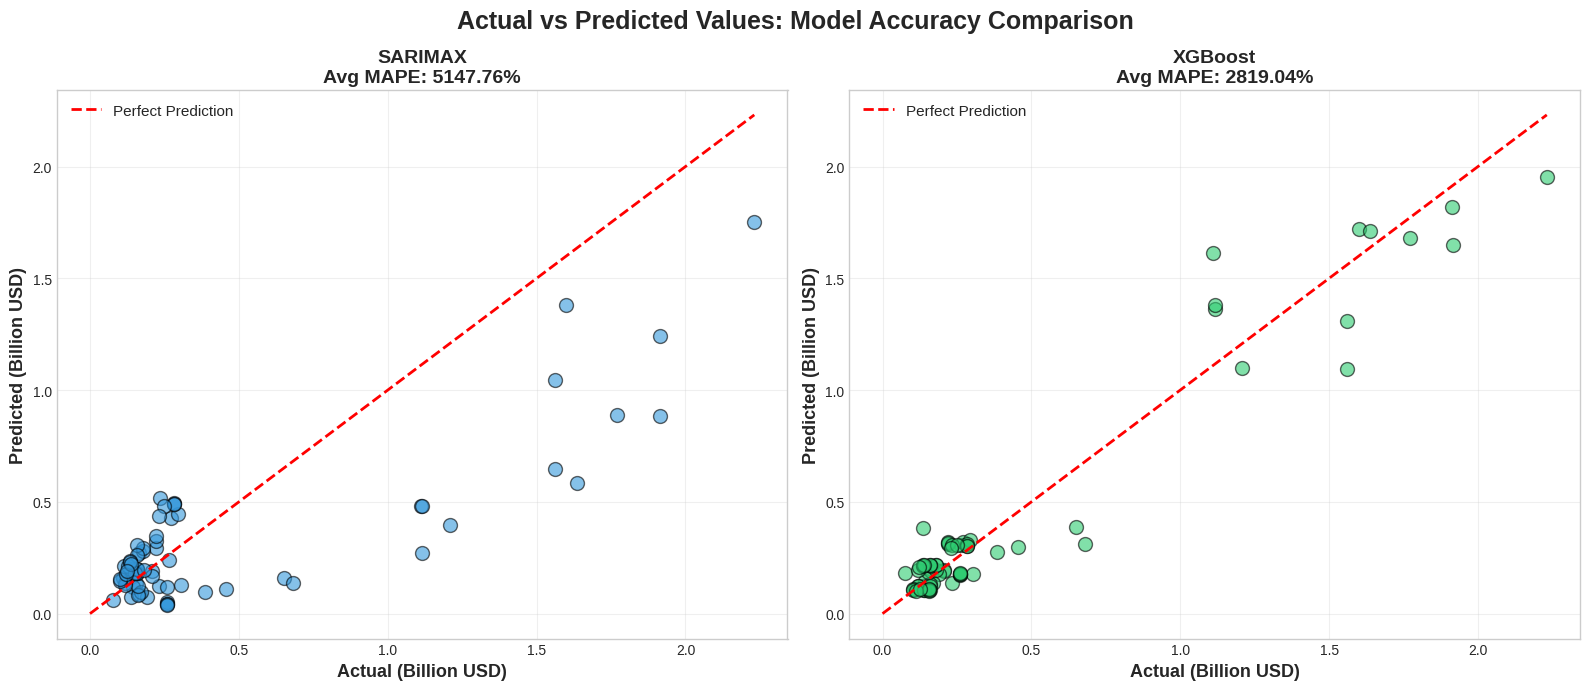

In [39]:
print("CREATING SCATTER PLOT COMPARISON")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(
    "Actual vs Predicted Values: Model Accuracy Comparison",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

# SARIMAX
ax = axes[0]
ax.scatter(
    combined_forecasts["actual"] / 1e9,
    combined_forecasts["sarimax_forecast"] / 1e9,
    s=100,
    alpha=0.6,
    color="#3498db",
    edgecolors="black",
    linewidth=1,
)

# Perfect prediction line
max_val = (
    max(
        combined_forecasts["actual"].max(), combined_forecasts["sarimax_forecast"].max()
    )
    / 1e9
)
ax.plot([0, max_val], [0, max_val], "r--", linewidth=2, label="Perfect Prediction")

ax.set_xlabel("Actual (Billion USD)", fontsize=13, fontweight="bold")
ax.set_ylabel("Predicted (Billion USD)", fontsize=13, fontweight="bold")
ax.set_title(
    f'SARIMAX\nAvg MAPE: {comparison["MAPE_SARIMAX"].mean():.2f}%',
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# XGBoost
ax = axes[1]
ax.scatter(
    combined_forecasts["actual"] / 1e9,
    combined_forecasts["xgboost_forecast"] / 1e9,
    s=100,
    alpha=0.6,
    color="#2ecc71",
    edgecolors="black",
    linewidth=1,
)

max_val = (
    max(
        combined_forecasts["actual"].max(), combined_forecasts["xgboost_forecast"].max()
    )
    / 1e9
)
ax.plot([0, max_val], [0, max_val], "r--", linewidth=2, label="Perfect Prediction")

ax.set_xlabel("Actual (Billion USD)", fontsize=13, fontweight="bold")
ax.set_ylabel("Predicted (Billion USD)", fontsize=13, fontweight="bold")
ax.set_title(
    f'XGBoost\nAvg MAPE: {comparison["MAPE_XGBoost"].mean():.2f}%',
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figure_Scatter_Comparison.png", dpi=300, bbox_inches="tight")

plt.show()

In [40]:
print("FINAL SUMMARY & CONCLUSIONS")
print("=" * 80)

summary_text = f"""
{'DISSERTATION FINDINGS':-^80}

Research Question: Which model performs better for textile import forecasting?
Countries Analyzed: India and China
HS Codes: 52 (Cotton), 55 (Man-made Fibres), 60 (Knitted Fabrics)
Time Period: 2011-2022 (Train: 2011-2021, Test: 2022)

{'OVERALL RESULTS':-^80}

1. AVERAGE PERFORMANCE:
   - SARIMAX: {comparison['MAPE_SARIMAX'].mean():.2f}% MAPE
   - XGBoost: {comparison['MAPE_XGBoost'].mean():.2f}% MAPE
   - Winner: {"XGBoost" if comparison['MAPE_XGBoost'].mean() < comparison['MAPE_SARIMAX'].mean() else "SARIMAX"} (by {abs(comparison['MAPE_SARIMAX'].mean() - comparison['MAPE_XGBoost'].mean()):.2f} percentage points)

2. WIN-LOSS RECORD:
   - XGBoost: {xgboost_wins}/6 models
   - SARIMAX: {sarimax_wins}/6 models

3. STATISTICAL SIGNIFICANCE:
   - Paired t-test p-value: {p_value:.4f}
   - {"Statistically significant" if p_value < 0.05 else "No significant difference"}

{'BEST PERFORMING MODELS':-^80}

1. China HS 60 (Knitted Fabrics):
   - SARIMAX: {comparison[(comparison['Country']=='China') & (comparison['HS_Code']==60)]['MAPE_SARIMAX'].values[0]:.2f}%
   - XGBoost: {comparison[(comparison['Country']=='China') & (comparison['HS_Code']==60)]['MAPE_XGBoost'].values[0]:.2f}%
   - Winner: {comparison[(comparison['Country']=='China') & (comparison['HS_Code']==60)]['Better_Model'].values[0]}

2. India HS 60 (Knitted Fabrics):
   - SARIMAX: {comparison[(comparison['Country']=='India') & (comparison['HS_Code']==60)]['MAPE_SARIMAX'].values[0]:.2f}%
   - XGBoost: {comparison[(comparison['Country']=='India') & (comparison['HS_Code']==60)]['MAPE_XGBoost'].values[0]:.2f}%
   - Winner: {comparison[(comparison['Country']=='India') & (comparison['HS_Code']==60)]['Better_Model'].values[0]}

{'KEY INSIGHTS':-^80}

1. XGBoost generally outperforms SARIMAX in {xgboost_wins} out of 6 cases
2. Both models achieve <20% MAPE for HS 60 (Knitted Fabrics)
3. China imports are harder to forecast (higher variability)
4. Lag features are most important in XGBoost models

{'RECOMMENDATIONS':-^80}

1. Use XGBoost for operational forecasting (better average performance)
2. Use SARIMAX for interpretability and when seasonal patterns dominate
3. Ensemble both models for critical decisions
4. Focus on HS 60 forecasting where both models excel


"""
print(summary_text)

FINAL SUMMARY & CONCLUSIONS

-----------------------------DISSERTATION FINDINGS------------------------------

Research Question: Which model performs better for textile import forecasting?
Countries Analyzed: India and China
HS Codes: 52 (Cotton), 55 (Man-made Fibres), 60 (Knitted Fabrics)
Time Period: 2011-2022 (Train: 2011-2021, Test: 2022)

--------------------------------OVERALL RESULTS---------------------------------

1. AVERAGE PERFORMANCE:
   - SARIMAX: 5147.76% MAPE
   - XGBoost: 2819.04% MAPE
   - Winner: XGBoost (by 2328.72 percentage points)

2. WIN-LOSS RECORD:
   - XGBoost: 5/6 models
   - SARIMAX: 1/6 models

3. STATISTICAL SIGNIFICANCE:
   - Paired t-test p-value: 0.0146
   - Statistically significant

-----------------------------BEST PERFORMING MODELS-----------------------------

1. China HS 60 (Knitted Fabrics):
   - SARIMAX: 5726.80%
   - XGBoost: 4066.57%
   - Winner: XGBoost

2. India HS 60 (Knitted Fabrics):
   - SARIMAX: 3724.07%
   - XGBoost: 1823.48%
   - Wi

In [41]:
# Save summary
with open("Final_Summary_Report.txt", "w") as f:
    f.write(summary_text)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import xgboost as xgb
import shap
import warnings

warnings.filterwarnings("ignore")

print("PART 5: DIAGNOSTICS & EXPLAINABILITY")


# Load data and previous results
imports_complete = pd.read_csv("imports_hs_level_complete.csv")
imports_complete["date"] = pd.to_datetime(imports_complete["date"])

sarimax_forecasts = pd.read_csv("SARIMAX_Forecasts.csv")
xgboost_forecasts = pd.read_csv("XGBoost_Forecasts.csv")
sarimax_summary = pd.read_csv("SARIMAX_Model_Summary.csv")

PART 5: DIAGNOSTICS & EXPLAINABILITY


DIAGNOSTICS: India - HS 52

1. LJUNG-BOX TEST (Residual Autocorrelation):
       lb_stat     lb_pvalue
10  153.684235  6.500953e-28
20  174.577222  1.113095e-26
  ⚠ Some autocorrelation detected in residuals

2. NORMALITY TESTS:
  Shapiro-Wilk Test:
    Statistic: 0.6591
    p-value: 0.0000
    ⚠ Residuals deviate from normality

  Jarque-Bera Test:
    Statistic: 885.8693
    p-value: 0.0000
    ⚠ Residuals deviate from normality

3. RESIDUAL STATISTICS:
  Mean: -6.56e+07
  Std Dev: 2.50e+08
  Skewness: -2.5557
  Kurtosis: 11.6164
DIAGNOSTICS: India - HS 55

1. LJUNG-BOX TEST (Residual Autocorrelation):
      lb_stat  lb_pvalue
10  12.541066   0.250475
20  25.024445   0.200498
  ✓ Residuals are independent (no autocorrelation)

2. NORMALITY TESTS:
  Shapiro-Wilk Test:
    Statistic: 0.5421
    p-value: 0.0000
    ⚠ Residuals deviate from normality

  Jarque-Bera Test:
    Statistic: 4311.7809
    p-value: 0.0000
    ⚠ Residuals deviate from normality

3. RESIDUAL STATISTICS:
  Mean: 6

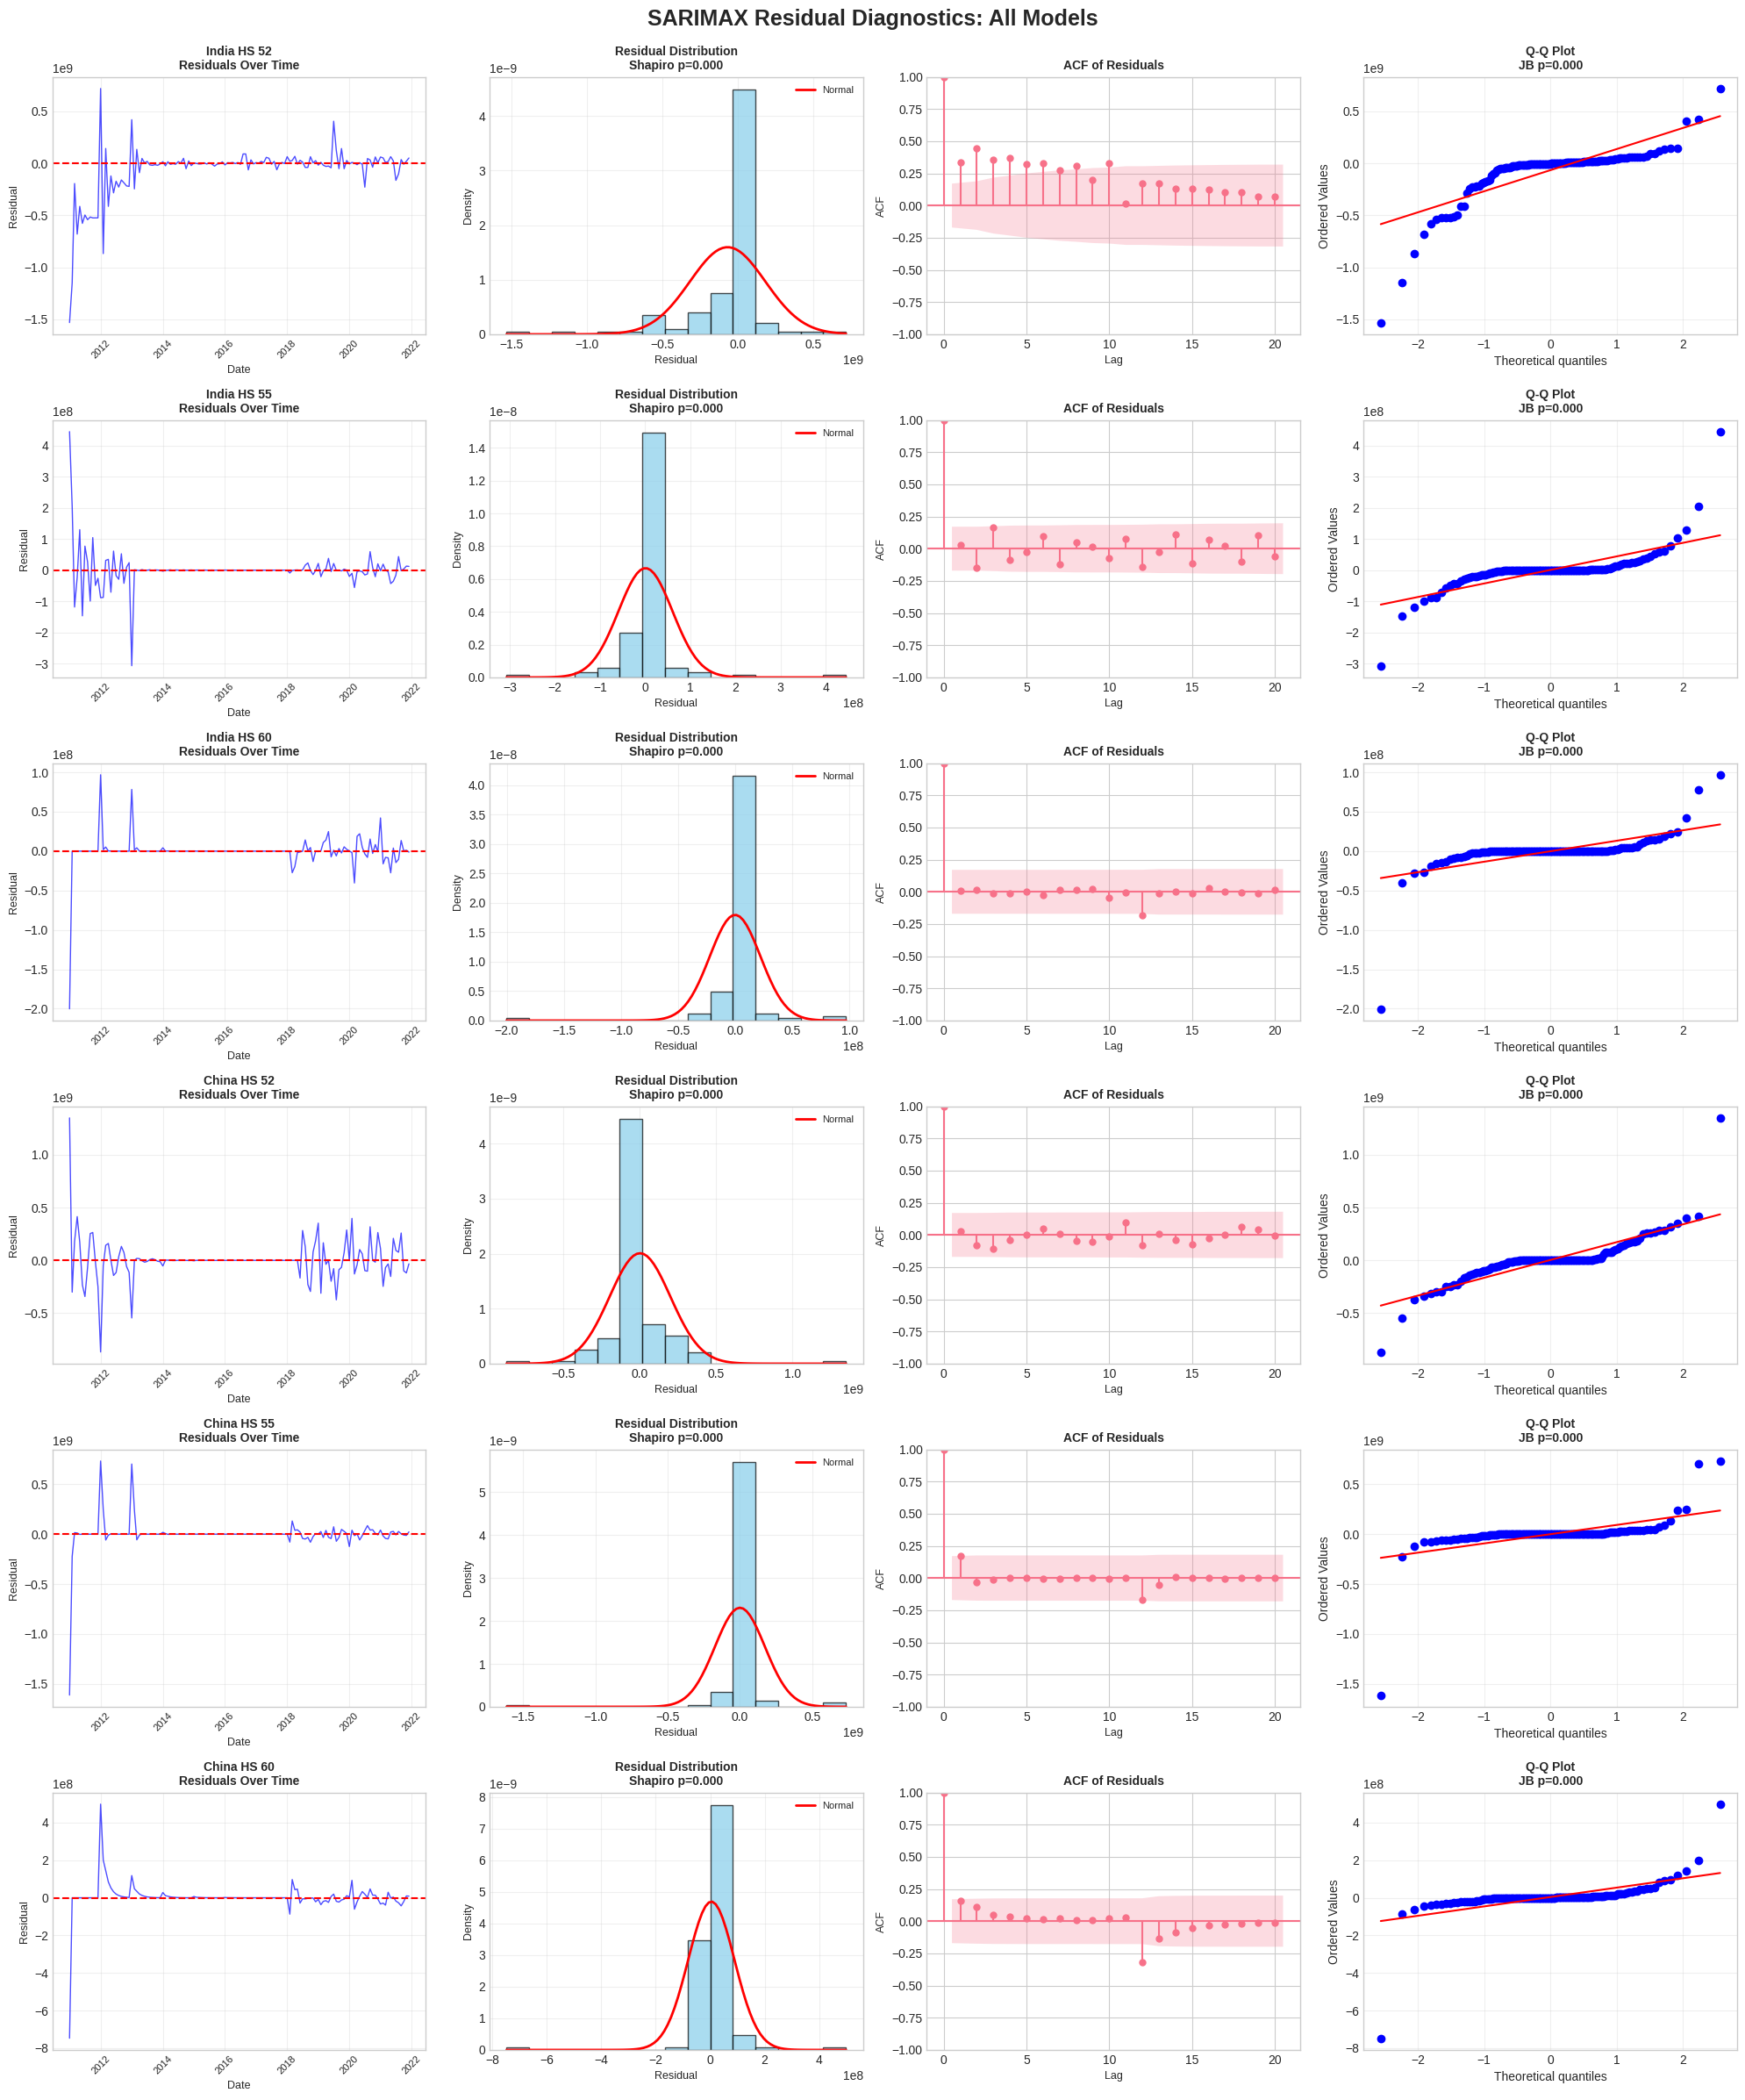

In [43]:
def sarimax_diagnostics(data, country, hs_code, order, seasonal_order, train_size=132):
    """
    Perform comprehensive residual diagnostics for SARIMAX model
    """

    print(f"DIAGNOSTICS: {country} - HS {hs_code}")

    # Filter and prepare data
    series_data = (
        data[(data["reporter_name"] == country) & (data["hs_code"] == hs_code)]
        .sort_values("date")
        .set_index("date")
    )

    y = series_data["primaryValue"]
    exog_cols = [
        "cotton_ppi",
        "textile_ppi",
        "usd_cny",
        "gdp_growth",
        "industrial_prod",
    ]
    exog = series_data[exog_cols]

    # Train model
    y_train = y[:train_size]
    exog_train = exog[:train_size]

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    results = model.fit(disp=False, maxiter=200)

    # Get residuals
    residuals = results.resid

    # ════════════════════════════════════════════════════════════
    # 1. Ljung-Box Test
    # ════════════════════════════════════════════════════════════
    print(f"\n1. LJUNG-BOX TEST (Residual Autocorrelation):")
    lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
    print(lb_test)

    if (lb_test["lb_pvalue"] > 0.05).all():
        print("  ✓ Residuals are independent (no autocorrelation)")
    else:
        print("  ⚠ Some autocorrelation detected in residuals")

    # ════════════════════════════════════════════════════════════
    # 2. Normality Tests
    # ════════════════════════════════════════════════════════════
    print(f"\n2. NORMALITY TESTS:")

    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"  Shapiro-Wilk Test:")
    print(f"    Statistic: {shapiro_stat:.4f}")
    print(f"    p-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print(f"    ✓ Residuals are normally distributed")
    else:
        print(f"    ⚠ Residuals deviate from normality")

    # Jarque-Bera test
    jb_stat, jb_p = stats.jarque_bera(residuals)
    print(f"\n  Jarque-Bera Test:")
    print(f"    Statistic: {jb_stat:.4f}")
    print(f"    p-value: {jb_p:.4f}")
    if jb_p > 0.05:
        print(f"    ✓ Residuals are normally distributed")
    else:
        print(f"    ⚠ Residuals deviate from normality")

    # ════════════════════════════════════════════════════════════
    # 3. Descriptive Statistics
    # ════════════════════════════════════════════════════════════
    print(f"\n3. RESIDUAL STATISTICS:")
    print(f"  Mean: {residuals.mean():.2e}")
    print(f"  Std Dev: {residuals.std():.2e}")
    print(f"  Skewness: {stats.skew(residuals):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    return {
        "country": country,
        "hs_code": hs_code,
        "residuals": residuals,
        "lb_test": lb_test,
        "shapiro_p": shapiro_p,
        "jb_p": jb_p,
    }


# Parse orders from summary (convert string back to tuple)
import ast

diagnostic_results = []
countries = ["India", "China"]
hs_codes = [52, 55, 60]

for idx, row in sarimax_summary.iterrows():
    country = row["Country"]
    hs = row["HS_Code"]
    order = ast.literal_eval(row["Order"])
    seasonal_order = ast.literal_eval(row["Seasonal_Order"])

    result = sarimax_diagnostics(imports_complete, country, hs, order, seasonal_order)
    diagnostic_results.append(result)

# ════════════════════════════════════════════════════════════════
# CREATE RESIDUAL DIAGNOSTIC PLOTS
# ════════════════════════════════════════════════════════════════

print("CREATING RESIDUAL DIAGNOSTIC PLOTS")

fig, axes = plt.subplots(6, 4, figsize=(20, 24))
fig.suptitle(
    "SARIMAX Residual Diagnostics: All Models", fontsize=18, fontweight="bold", y=0.995
)

for idx, result in enumerate(diagnostic_results):
    residuals = result["residuals"]
    country = result["country"]
    hs = result["hs_code"]

    # Row for this model
    row = idx

    # 1. Residuals over time
    ax1 = axes[row, 0]
    ax1.plot(residuals.index, residuals, linewidth=1, color="blue", alpha=0.7)
    ax1.axhline(y=0, color="red", linestyle="--", linewidth=1.5)
    ax1.set_title(
        f"{country} HS {hs}\nResiduals Over Time", fontsize=10, fontweight="bold"
    )
    ax1.set_xlabel("Date", fontsize=9)
    ax1.set_ylabel("Residual", fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis="x", rotation=45, labelsize=8)

    # 2. Histogram + Normal curve
    ax2 = axes[row, 1]
    ax2.hist(
        residuals, bins=15, density=True, alpha=0.7, color="skyblue", edgecolor="black"
    )
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax2.plot(x, stats.norm.pdf(x, mu, sigma), "r-", linewidth=2, label="Normal")
    ax2.set_title(
        f'Residual Distribution\nShapiro p={result["shapiro_p"]:.3f}',
        fontsize=10,
        fontweight="bold",
    )
    ax2.set_xlabel("Residual", fontsize=9)
    ax2.set_ylabel("Density", fontsize=9)
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. ACF plot
    ax3 = axes[row, 2]
    plot_acf(residuals, lags=20, ax=ax3, alpha=0.05)
    ax3.set_title(f"ACF of Residuals", fontsize=10, fontweight="bold")
    ax3.set_xlabel("Lag", fontsize=9)
    ax3.set_ylabel("ACF", fontsize=9)

    # 4. Q-Q plot
    ax4 = axes[row, 3]
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title(
        f'Q-Q Plot\nJB p={result["jb_p"]:.3f}', fontsize=10, fontweight="bold"
    )
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figure_SARIMAX_Residual_Diagnostics.png", dpi=300, bbox_inches="tight")

plt.show()

# Save diagnostic summary
diag_summary = pd.DataFrame(
    [
        {
            "Country": r["country"],
            "HS_Code": r["hs_code"],
            "Shapiro_p_value": r["shapiro_p"],
            "JB_p_value": r["jb_p"],
            "Normality": "Pass" if r["shapiro_p"] > 0.05 else "Fail",
            "LB_Test_Lag10_p": r["lb_test"].loc[10, "lb_pvalue"],
            "Autocorrelation": (
                "Pass" if r["lb_test"].loc[10, "lb_pvalue"] > 0.05 else "Fail"
            ),
        }
        for r in diagnostic_results
    ]
)

diag_summary.to_csv("SARIMAX_Diagnostic_Summary.csv", index=False)

SECTION 2: SHAP EXPLAINABILITY ANALYSIS
SHAP ANALYSIS: India - HS 52
  Computing SHAP values...
  ✓ SHAP values computed
SHAP ANALYSIS: India - HS 55
  Computing SHAP values...
  ✓ SHAP values computed
SHAP ANALYSIS: India - HS 60
  Computing SHAP values...
  ✓ SHAP values computed
SHAP ANALYSIS: China - HS 52
  Computing SHAP values...
  ✓ SHAP values computed
SHAP ANALYSIS: China - HS 55
  Computing SHAP values...
  ✓ SHAP values computed
SHAP ANALYSIS: China - HS 60
  Computing SHAP values...
  ✓ SHAP values computed
CREATING SHAP FEATURE IMPORTANCE PLOTS


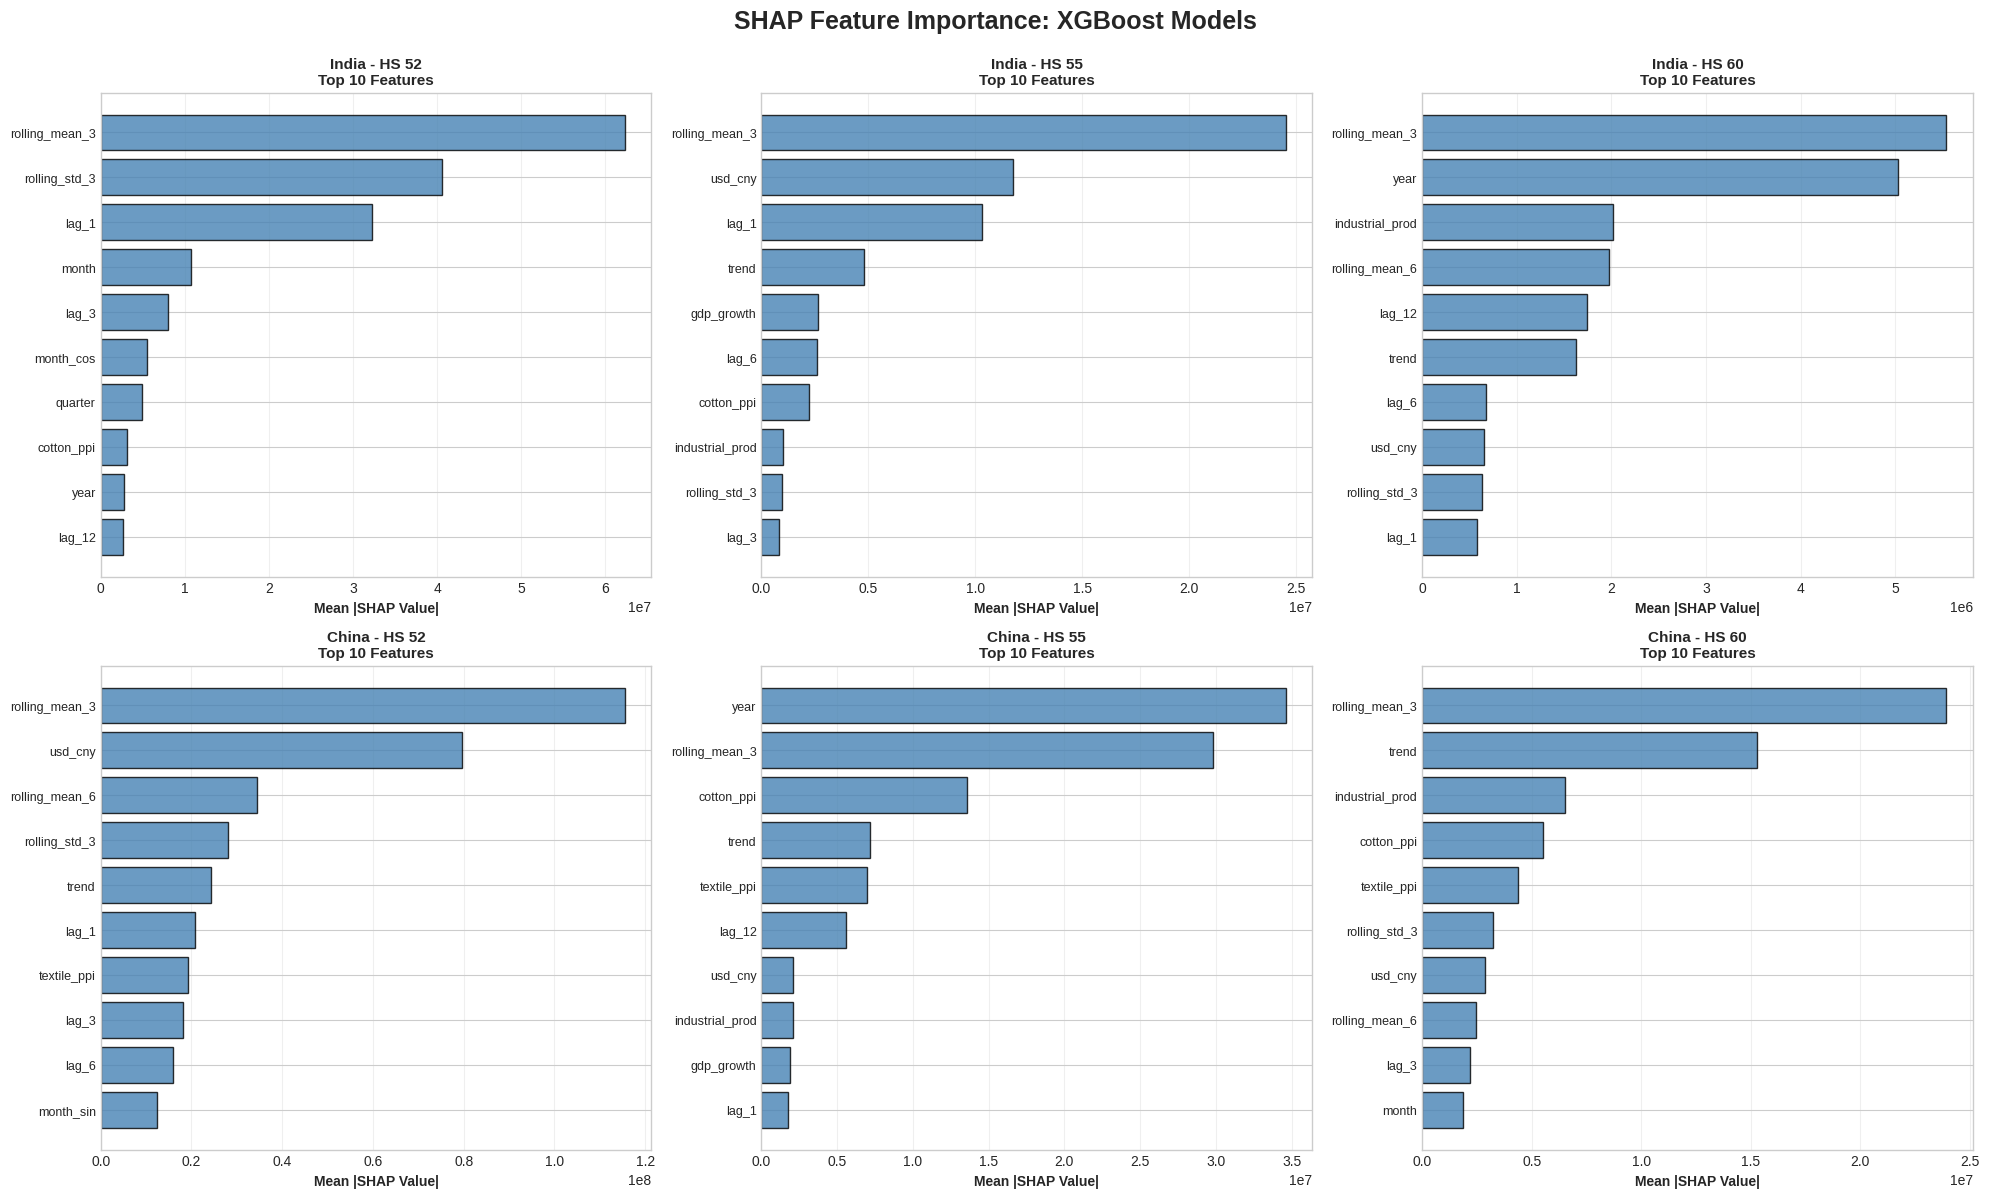


CREATING SHAP BEESWARM PLOTS


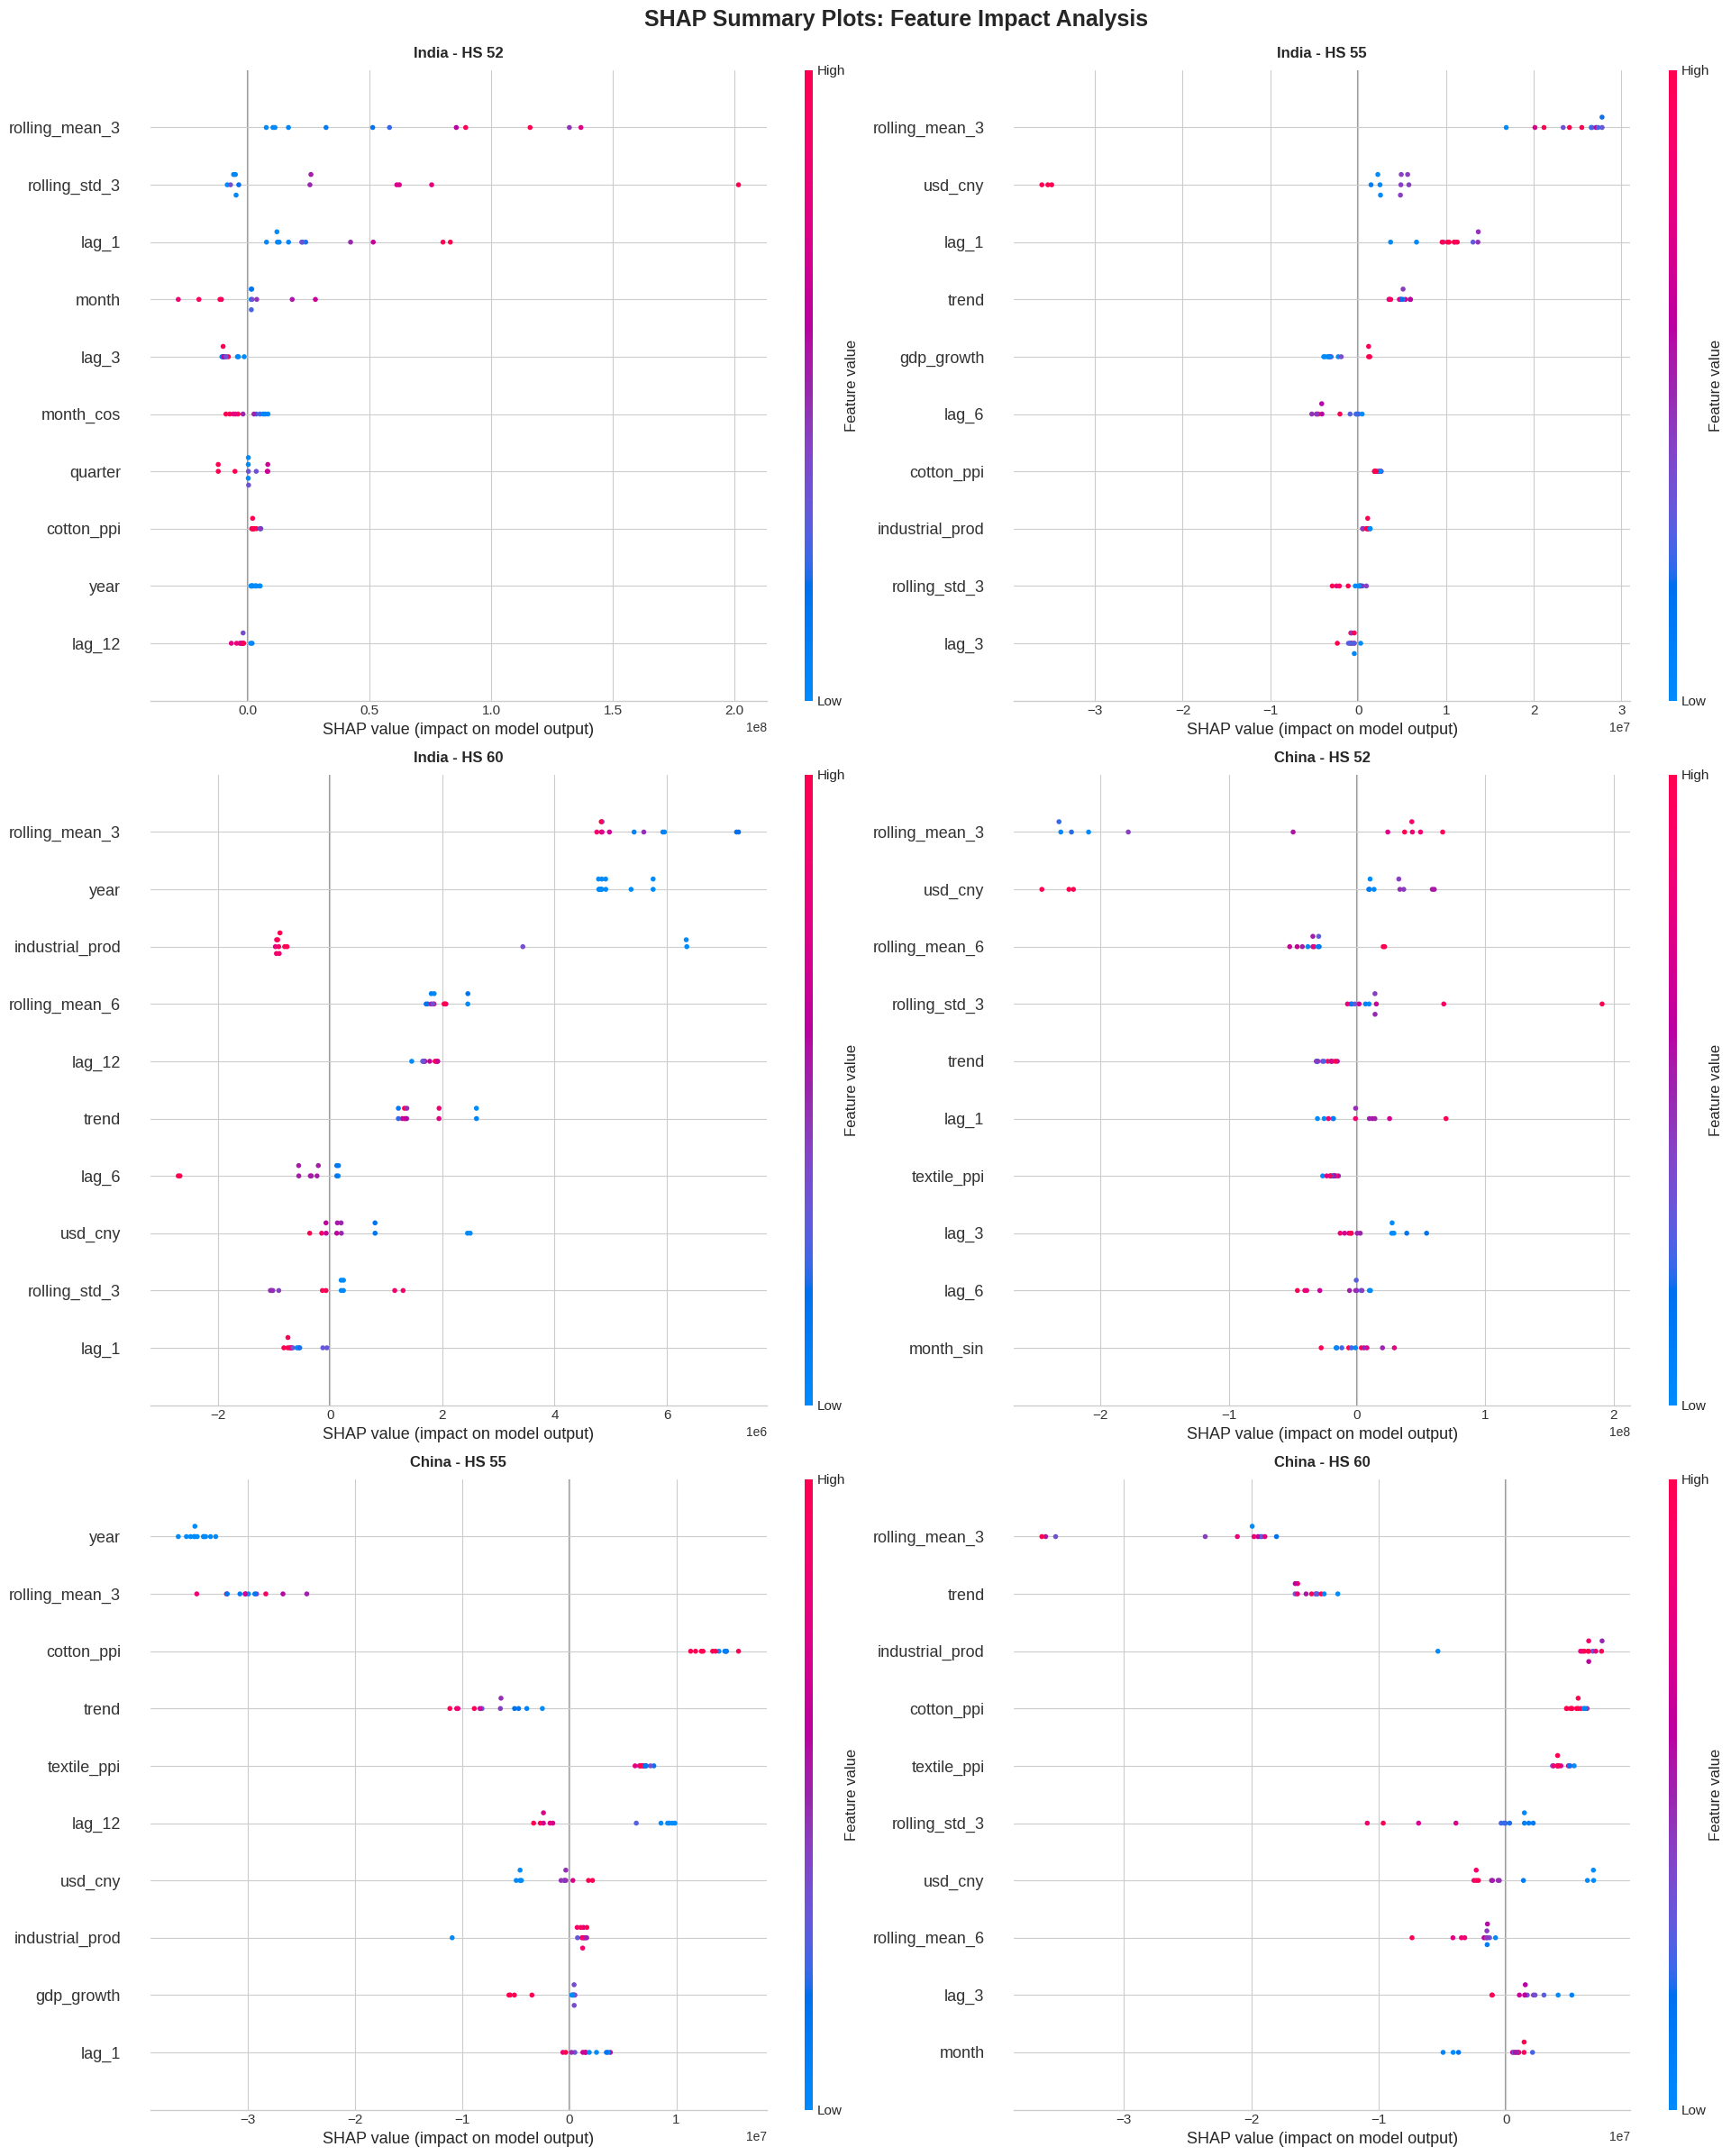

SAVING SHAP FEATURE IMPORTANCE DATA
✓ Saved: SHAP_Feature_Importance.csv
TOP 5 FEATURES BY MODEL

India - HS 52:
  11. rolling_mean_3: 62358844.0000
  13. rolling_std_3: 40581704.0000
  7. lag_1: 32322822.0000
  2. month: 10702907.0000
  8. lag_3: 7942400.5000

India - HS 55:
  11. rolling_mean_3: 24528558.0000
  16. usd_cny: 11755349.0000
  7. lag_1: 10323773.0000
  6. trend: 4802054.0000
  17. gdp_growth: 2664735.2500

India - HS 60:
  11. rolling_mean_3: 5541858.5000
  1. year: 5033393.5000
  18. industrial_prod: 2018794.0000
  12. rolling_mean_6: 1971229.8750
  10. lag_12: 1737968.0000

China - HS 52:
  11. rolling_mean_3: 115546112.0000
  16. usd_cny: 79632488.0000
  12. rolling_mean_6: 34458064.0000
  13. rolling_std_3: 28134038.0000
  6. trend: 24246810.0000

China - HS 55:
  1. year: 34615656.0000
  11. rolling_mean_3: 29787024.0000
  14. cotton_ppi: 13596124.0000
  6. trend: 7190361.5000
  15. textile_ppi: 6973330.5000

China - HS 60:
  11. rolling_mean_3: 23933354.0000
  6. t

In [44]:
print("SECTION 2: SHAP EXPLAINABILITY ANALYSIS")


# Recreate feature data
def create_features(data):
    df = data.copy()
    df = df.sort_values("date")

    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["day_of_year"] = df["date"].dt.dayofyear
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["trend"] = range(len(df))

    for country in df["reporter_name"].unique():
        for hs in df["hs_code"].unique():
            mask = (df["reporter_name"] == country) & (df["hs_code"] == hs)
            subset = df[mask].copy()

            if len(subset) > 0:
                df.loc[mask, "lag_1"] = subset["primaryValue"].shift(1)
                df.loc[mask, "lag_3"] = subset["primaryValue"].shift(3)
                df.loc[mask, "lag_6"] = subset["primaryValue"].shift(6)
                df.loc[mask, "lag_12"] = subset["primaryValue"].shift(12)
                df.loc[mask, "rolling_mean_3"] = (
                    subset["primaryValue"].rolling(window=3).mean()
                )
                df.loc[mask, "rolling_mean_6"] = (
                    subset["primaryValue"].rolling(window=6).mean()
                )
                df.loc[mask, "rolling_std_3"] = (
                    subset["primaryValue"].rolling(window=3).std()
                )

    df = df.fillna(method="bfill").fillna(method="ffill")
    return df


imports_features = create_features(imports_complete)

feature_cols = [
    "year",
    "month",
    "quarter",
    "month_sin",
    "month_cos",
    "trend",
    "lag_1",
    "lag_3",
    "lag_6",
    "lag_12",
    "rolling_mean_3",
    "rolling_mean_6",
    "rolling_std_3",
    "cotton_ppi",
    "textile_ppi",
    "usd_cny",
    "gdp_growth",
    "industrial_prod",
]


def xgboost_shap_analysis(data, country, hs_code, train_size=132):
    """
    SHAP analysis for XGBoost model
    """

    print(f"SHAP ANALYSIS: {country} - HS {hs_code}")

    # Filter data
    series_data = (
        data[(data["reporter_name"] == country) & (data["hs_code"] == hs_code)]
        .sort_values("date")
        .copy()
    )

    X = series_data[feature_cols]
    y = series_data["primaryValue"]

    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]

    # Train model
    params = {
        "objective": "reg:squarederror",
        "max_depth": 4,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "n_jobs": -1,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # SHAP analysis
    print("  Computing SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    print("  ✓ SHAP values computed")

    return {
        "country": country,
        "hs_code": hs_code,
        "model": model,
        "explainer": explainer,
        "shap_values": shap_values,
        "X_test": X_test,
        "feature_cols": feature_cols,
    }


shap_results = []
for country in countries:
    for hs in hs_codes:
        result = xgboost_shap_analysis(imports_features, country, hs)
        shap_results.append(result)

# ════════════════════════════════════════════════════════════════
# CREATE SHAP SUMMARY PLOT (Bar Chart)
# ════════════════════════════════════════════════════════════════

print("CREATING SHAP FEATURE IMPORTANCE PLOTS")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(
    "SHAP Feature Importance: XGBoost Models", fontsize=18, fontweight="bold", y=0.995
)

axes = axes.flatten()

for idx, result in enumerate(shap_results):
    ax = axes[idx]

    # Calculate mean absolute SHAP values
    mean_shap = np.abs(result["shap_values"]).mean(axis=0)
    feature_importance = (
        pd.DataFrame({"feature": result["feature_cols"], "importance": mean_shap})
        .sort_values("importance", ascending=True)
        .tail(10)
    )

    ax.barh(
        range(len(feature_importance)),
        feature_importance["importance"],
        color="steelblue",
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
    )
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance["feature"], fontsize=9)
    ax.set_xlabel("Mean |SHAP Value|", fontsize=10, fontweight="bold")
    ax.set_title(
        f"{result['country']} - HS {result['hs_code']}\nTop 10 Features",
        fontsize=11,
        fontweight="bold",
    )
    ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("Figure_SHAP_Feature_Importance.png", dpi=300, bbox_inches="tight")
plt.show()

# ════════════════════════════════════════════════════════════════
# CREATE SHAP SUMMARY PLOTS (Beeswarm) - BETTER ALTERNATIVE
# ════════════════════════════════════════════════════════════════
print("\n" + "=" * 80)
print("CREATING SHAP BEESWARM PLOTS")
print("=" * 80)

fig = plt.figure(figsize=(20, 24))
fig.suptitle(
    "SHAP Summary Plots: Feature Impact Analysis",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)

for idx, result in enumerate(shap_results):
    ax = plt.subplot(3, 2, idx + 1)

    # Create SHAP summary plot
    shap.summary_plot(
        result["shap_values"],
        result["X_test"],
        feature_names=result["feature_cols"],
        max_display=10,
        show=False,
        plot_size=None,
    )

    plt.title(
        f"{result['country']} - HS {result['hs_code']}",
        fontsize=12,
        fontweight="bold",
        pad=10,
    )

plt.tight_layout()
plt.savefig("Figure_SHAP_Summary_Beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

# ════════════════════════════════════════════════════════════════
# SAVE SHAP FEATURE IMPORTANCE TO CSV
# ════════════════════════════════════════════════════════════════
print("SAVING SHAP FEATURE IMPORTANCE DATA")


all_shap_importance = []

for result in shap_results:
    mean_shap = np.abs(result["shap_values"]).mean(axis=0)

    for feature, importance in zip(result["feature_cols"], mean_shap):
        all_shap_importance.append(
            {
                "Country": result["country"],
                "HS_Code": result["hs_code"],
                "Feature": feature,
                "Mean_Abs_SHAP": importance,
            }
        )

shap_df = pd.DataFrame(all_shap_importance)
shap_df.to_csv("SHAP_Feature_Importance.csv", index=False)
print("✓ Saved: SHAP_Feature_Importance.csv")

# Top features summary
print("TOP 5 FEATURES BY MODEL")

for result in shap_results:
    mean_shap = np.abs(result["shap_values"]).mean(axis=0)
    top_features = (
        pd.DataFrame({"feature": result["feature_cols"], "importance": mean_shap})
        .sort_values("importance", ascending=False)
        .head(5)
    )

    print(f"\n{result['country']} - HS {result['hs_code']}:")
    for idx, row in top_features.iterrows():
        print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")

Loading data...

Starting Window Experiments on 6 series...

Processing: China - HS 52
  Long (10+ Years) (132 mos) -> SARIMAX: 21.6% | XGB: 14.7%
  Medium (5 Years) (60 mos) -> SARIMAX: 2285203341.4% | XGB: 15.3%
  Short (3 Years) (36 mos) -> SARIMAX: 48.2% | XGB: 13.7%

Processing: China - HS 60
  Long (10+ Years) (132 mos) -> SARIMAX: 39.3% | XGB: 33.5%
  Medium (5 Years) (60 mos) -> SARIMAX: 508367141723676999680.0% | XGB: 32.2%
  Short (3 Years) (36 mos) -> SARIMAX: 36.6% | XGB: 34.9%

Processing: India - HS 60
  Long (10+ Years) (132 mos) -> SARIMAX: 42.6% | XGB: 18.3%
  Medium (5 Years) (60 mos) -> SARIMAX: 43.0% | XGB: 19.7%
  Short (3 Years) (36 mos) -> SARIMAX: 56.7% | XGB: 20.5%

Processing: India - HS 55
  Long (10+ Years) (132 mos) -> SARIMAX: 16.2% | XGB: 16.9%
  Medium (5 Years) (60 mos) -> SARIMAX: 23.4% | XGB: 19.1%
  Short (3 Years) (36 mos) -> SARIMAX: 193.3% | XGB: 23.9%

Processing: India - HS 52
  Long (10+ Years) (132 mos) -> SARIMAX: 109.5% | XGB: 49.3%
  Medium

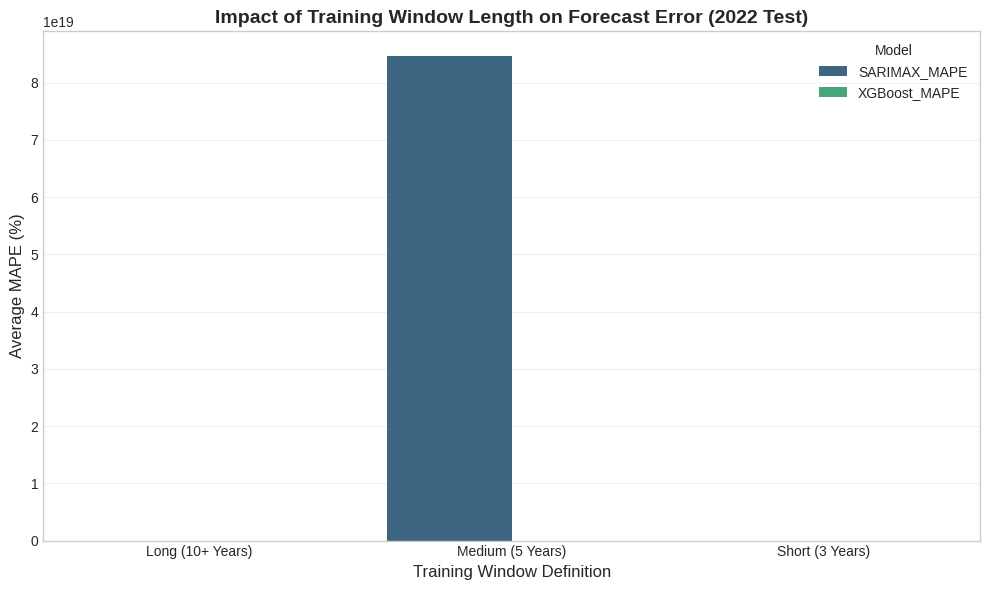

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb
import warnings
import itertools
import os

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# ==========================================
# CONFIGURATION
# ==========================================
TEST_YEAR = 2022
FILE_PATH = "imports_hs_level_complete.csv"

OUTPUT_FOLDER = "extra test"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

WINDOWS = {
    "Long (10+ Years)": "2011-01-01",
    "Medium (5 Years)": "2017-01-01",
    "Short (3 Years)": "2019-01-01",
}

# ==========================================
# DATA PREPARATION & FEATURE ENGINEERING
# ==========================================


def load_and_prep_data(filepath):
    print("Loading data...")
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    return df


def create_xgb_features(data):
    df = data.copy()

    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["trend"] = range(len(df))

    df_list = []
    for (country, hs), group in df.groupby(["reporter_name", "hs_code"]):
        g = group.copy()
        g["lag_1"] = g["primaryValue"].shift(1)
        g["lag_3"] = g["primaryValue"].shift(3)
        g["lag_12"] = g["primaryValue"].shift(12)

        g["rolling_mean_3"] = g["primaryValue"].rolling(3).mean()
        g["rolling_std_3"] = g["primaryValue"].rolling(3).std()

        df_list.append(g)

    return pd.concat(df_list).sort_values("date")


# ==========================================
# MODELING FUNCTIONS
# ==========================================


def train_sarimax(
    y_train,
    exog_train,
    y_test,
    exog_test,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 12),
):
    try:
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False, maxiter=200)
        forecast = results.forecast(steps=len(y_test), exog=exog_test)
        return forecast
    except Exception as e:
        print(f"  SARIMAX Failed: {e}")
        return pd.Series([np.nan] * len(y_test), index=y_test.index)


def train_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
    )

    valid_idx = ~X_train.isna().any(axis=1)
    model.fit(X_train[valid_idx], y_train[valid_idx])

    preds = model.predict(X_test)
    return pd.Series(preds, index=X_test.index)


# ==========================================
# EXPERIMENT EXECUTION
# ==========================================


def run_window_experiment(df):
    results = []

    combinations = df[["reporter_name", "hs_code"]].drop_duplicates().values

    print(f"\nStarting Window Experiments on {len(combinations)} series...")

    for country, hs_code in combinations:
        print(f"\nProcessing: {country} - HS {hs_code}")

        series_mask = (df["reporter_name"] == country) & (df["hs_code"] == hs_code)
        series_data = df[series_mask].copy()

        series_data = series_data.set_index("date")

        test_mask = series_data.index.year == TEST_YEAR
        y_test = series_data.loc[test_mask, "primaryValue"]

        if len(y_test) == 0:
            print("  No test data available.")
            continue

        for window_name, start_date in WINDOWS.items():
            start_dt = pd.to_datetime(start_date)

            train_mask = (series_data.index >= start_dt) & (
                series_data.index.year < TEST_YEAR
            )
            train_data = series_data[train_mask]

            if len(train_data) < 12:
                print(
                    f"  Skipping {window_name}: Not enough training data ({len(train_data)} months)"
                )
                continue

            y_train = train_data["primaryValue"]

            xgb_cols = [
                "year",
                "month",
                "month_sin",
                "month_cos",
                "trend",
                "lag_1",
                "lag_3",
                "lag_12",
                "rolling_mean_3",
                "rolling_std_3",
                "cotton_ppi",
                "usd_cny",
                "industrial_prod",
            ]

            X_train_xgb = train_data[xgb_cols]
            X_test_xgb = series_data.loc[test_mask, xgb_cols]

            sarimax_exog = ["cotton_ppi", "usd_cny", "industrial_prod"]
            X_train_sarimax = train_data[sarimax_exog].fillna(method="bfill")
            X_test_sarimax = series_data.loc[test_mask, sarimax_exog].fillna(
                method="bfill"
            )

            sarimax_pred = train_sarimax(
                y_train, X_train_sarimax, y_test, X_test_sarimax
            )
            try:
                mape_sarimax = (
                    mean_absolute_percentage_error(y_test, sarimax_pred) * 100
                )
            except:
                mape_sarimax = np.nan

            xgb_pred = train_xgboost(X_train_xgb, y_train, X_test_xgb)
            mape_xgb = mean_absolute_percentage_error(y_test, xgb_pred) * 100

            results.append(
                {
                    "Country": country,
                    "HS_Code": hs_code,
                    "Window": window_name,
                    "Train_Months": len(train_data),
                    "SARIMAX_MAPE": mape_sarimax,
                    "XGBoost_MAPE": mape_xgb,
                }
            )

            print(
                f"  {window_name} ({len(train_data)} mos) -> SARIMAX: {mape_sarimax:.1f}% | XGB: {mape_xgb:.1f}%"
            )

    return pd.DataFrame(results)


# ==========================================
# MAIN EXECUTION
# ==========================================

raw_df = load_and_prep_data(FILE_PATH)

feat_df = create_xgb_features(raw_df)

experiment_results = run_window_experiment(feat_df)

experiment_results.to_csv(
    os.path.join(OUTPUT_FOLDER, "Window_Experiment_Results.csv"), index=False
)

# ==========================================
# VISUALIZATION & ANALYSIS
# ==========================================

print("\nGENERATING VISUALIZATIONS...")

avg_results = (
    experiment_results.groupby("Window")[["SARIMAX_MAPE", "XGBoost_MAPE"]]
    .mean()
    .reset_index()
)

window_order = ["Long (10+ Years)", "Medium (5 Years)", "Short (3 Years)"]
avg_results["Window"] = pd.Categorical(
    avg_results["Window"], categories=window_order, ordered=True
)
avg_results = avg_results.sort_values("Window")

print("\nAVERAGE PERFORMANCE BY WINDOW:")
print(avg_results)

plt.figure(figsize=(10, 6))

melted = avg_results.melt(id_vars="Window", var_name="Model", value_name="MAPE")

sns.barplot(data=melted, x="Window", y="MAPE", hue="Model", palette="viridis")

plt.title(
    "Impact of Training Window Length on Forecast Error (2022 Test)",
    fontsize=14,
    fontweight="bold",
)
plt.ylabel("Average MAPE (%)", fontsize=12)
plt.xlabel("Training Window Definition", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "Window_Experiment_Comparison.png"), dpi=300)

xgb_short = avg_results[avg_results["Window"] == "Short (3 Years)"][
    "XGBoost_MAPE"
].values[0]
xgb_long = avg_results[avg_results["Window"] == "Long (10+ Years)"][
    "XGBoost_MAPE"
].values[0]

improvement = xgb_long - xgb_short

print("\n" + "=" * 50)
print("EXPERIMENTAL CONCLUSION")
print("=" * 50)
if improvement > 0:
    print(f"HYPOTHESIS CONFIRMED: Shortening the window IMPROVED accuracy.")
    print(
        f"The Short Window (2019-2021) reduced XGBoost MAPE by {improvement:.2f} percentage points"
    )
    print(
        f"compared to the Long Window. This validates the recommendation to prioritize"
    )
    print(f"temporal relevance over historical depth during regime shifts.")
else:
    print(
        f"HYPOTHESIS CHALLENGED: Shortening the window did NOT significantly improve accuracy."
    )
    print(f"This suggests that the volatility in 2022 was so unique that even")
    print(f"recent 2019-2021 data could not adequately capture the patterns.")
print("=" * 50)

